# Gandal disorder genes

In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from gradientVersion import *
from mri_maps import *
from enrichments import *
from disorders import *
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Get gradients version with null weights from sim maps

In [4]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
pca_hcp_3d_ds8 = gradientVersion(approach='pca').fit('hcp_3donors_ds8')
pca_hcp_3d_ds5 = gradientVersion(approach='pca', kernel=None).fit('hcp_3donors_ds5')
# dm_hcp_ds9 = gradientVersion(approach='dm').fit('hcp_ds9')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5
New gradients version: method=pca, params={}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds8
New gradients version: method=pca, params={}, kernel=None, sparsity=0, data=hcp_3donors_ds5


In [5]:
version = dm_hcp_3d_ds5
scores = version.clean_scores()
weights = version.weights.iloc[:, :3]

In [601]:
# null_scores = version.make_null_scores(n=1000, save_name = 'hcp_3d_ds5_spin_1000')
# generate_spins_from_gradients(scores, n=1000, outfile='../outputs/permutations/hcp_3d_ds5_spin_1000.npy', atlas='hcp')
null_scores_sim = np.load('../outputs/permutations/hcp_3d_ds5_sim_10000.npy')
# null_scores_spin = np.load('../outputs/permutations/hcp_3d_ds5_spin_1000.npy')

In [505]:
# null_weights = version.make_null_weights(null_scores, save_name = 'pca_hcp_3d_ds8_spin_1000_weights')
# null_weights_sim = np.load('../outputs/permutations/hcp_3d_ds5_sim_1000_weights.npy')
# null_weights_sim = np.load('../outputs/permutations/hcp_3d_ds5_sim_10000_weights.npy')
# null_weights_spin = np.load('../outputs/permutations/hcp_3d_ds5_spin_1000_weights.npy')

In [799]:
null_weights_shuffle = shuffle_gene_weights(version.weights, n=2000, rank=False)

In [800]:
null_weights = null_weights_shuffle

## Rare genes

In [805]:
rare_genes = get_rare_genes()

In [704]:
true_, null_ = compute_enrichments(weights, null_weights, rare_genes)

In [705]:
null_p_rare = compute_null_p(true_, null_)

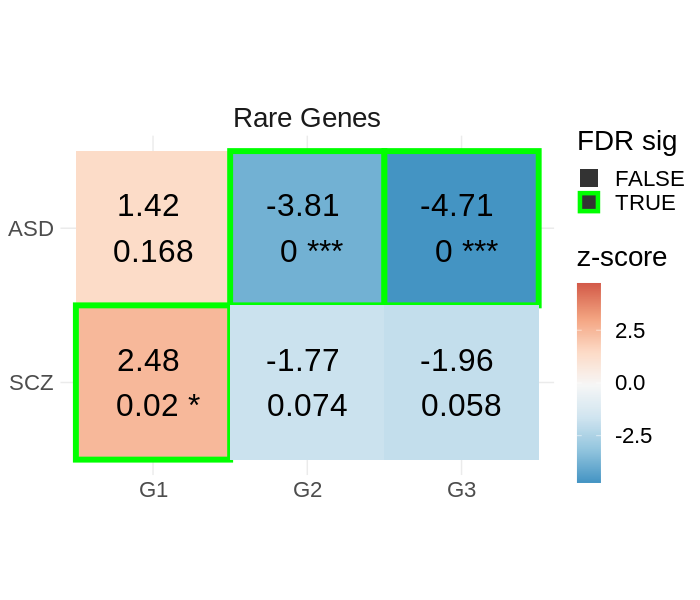

In [718]:
%%R -i null_p_rare -w 7 -h 6 --units in -r 100
source("../code/enrichmentsPlots.R")
null_p_rare %>% mutate(version='Rare Genes') %>%
plot_enrichment_heatmaps()

In [810]:
null_p_rare_versions_dict = {
    'Pos Weights': compute_null_p(*compute_enrichments(weights, null_weights, rare_genes, posneg='pos')),
    'Neg Weights': compute_null_p(*compute_enrichments(weights, null_weights, rare_genes, posneg='neg')),
}

null_p_versions = (pd.concat(null_p_rare_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

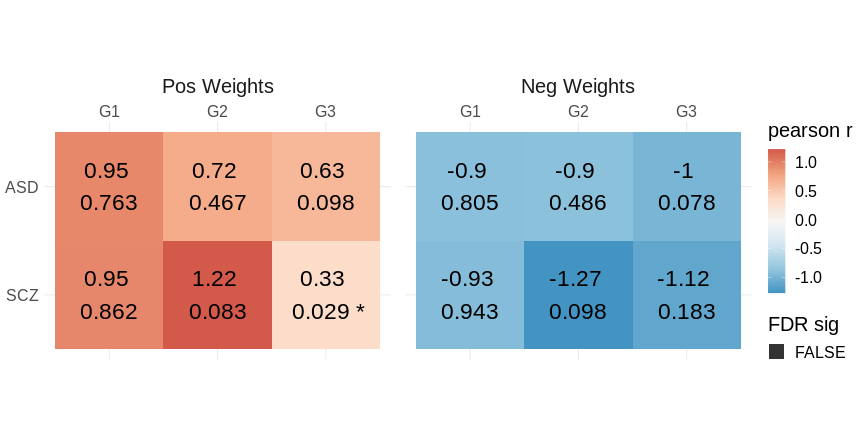

In [813]:
%%R -w 12 -h 6 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2)

## Gandal genes

In [579]:
gandal_genes_micro = get_gandal_genes(which='microarray')
gandal_genes_rna = get_gandal_genes(which='rnaseq')

## Overlaps

In [647]:
disorders = ['ASD','MDD','SCZ']
for d in disorders:
    gandal_genes_micro[f'{d}.sig'] = gandal_genes_micro[f'{d}.FDR'] < .05

(gandal_genes_micro
 .groupby([f'{d}.sig' for d in disorders])
 .size()
 .rename('n').reset_index()
 .assign(pct = lambda x: [n if n<10000 else np.nan for n in x['n']])
 .assign(pct = lambda x: round(x['pct']/x['pct'].sum(),2))
 .sort_values('pct', ascending=False)
)

ASD.sig  MDD.sig  SCZ.sig      n   pct
4     True    False    False   1864  0.45
1    False    False     True   1433  0.34
5     True    False     True    557  0.13
2    False     True    False    252  0.06
3    False     True     True     36  0.01
6     True     True    False     29  0.01
7     True     True     True     11  0.00
0    False    False    False  22341   NaN

In [694]:
gandal_sig = (gandal_genes_micro
              .loc[:,[f'{d}.sig' for d in disorders]]
              .melt(ignore_index=False, var_name='d', value_name='sig')
              .assign(d = lambda x: x['d'].str.replace('.sig','', regex=False))
              .set_index('d', append=True)
             )
gandal_sig

gandal_log2FC = (gandal_genes_micro
              .loc[:,[f'{d}.log2FC' for d in disorders]]
              .melt(ignore_index=False, var_name='d', value_name='log2FC')
              .assign(d = lambda x: x['d'].str.replace('.log2FC','', regex=False))
              .set_index('d', append=True)
              .join(gandal_sig)
              .reset_index(1)
                 )

gandal_overlap = (gandal_log2FC
                  .join(gandal_log2FC, lsuffix='_x', rsuffix='_y')
                  .dropna()
                  .loc[lambda x:
                       (x['d_x'] == 'ASD') & (x['d_y'] == 'SCZ') |
                       (x['d_x'] == 'MDD') & (x['d_y'] == 'SCZ') |
                       (x['d_x'] == 'MDD') & (x['d_y'] == 'ASD'), :]
                 )
gandal_overlap

d_x  log2FC_x  sig_x  d_y  log2FC_y  sig_y
gene                                                    
1.Dec         ASD  0.129671  False  SCZ -0.000311  False
1.Dec         MDD  0.021590  False  ASD  0.129671  False
1.Dec         MDD  0.021590  False  SCZ -0.000311  False
1.Mar         ASD  0.003611  False  SCZ  0.039644  False
1.Mar         MDD  0.077234  False  ASD  0.003611  False
...           ...       ...    ...  ...       ...    ...
ZZEF1         MDD -0.030545  False  SCZ -0.029585  False
ZZZ3          ASD  0.089637  False  SCZ  0.056258   True
ZZZ3          MDD -0.019721  False  ASD  0.089637  False
ZZZ3          MDD -0.019721  False  SCZ  0.056258   True
hsa-mir-5195  MDD -0.015952  False  ASD  0.108816  False

[39657 rows x 6 columns]

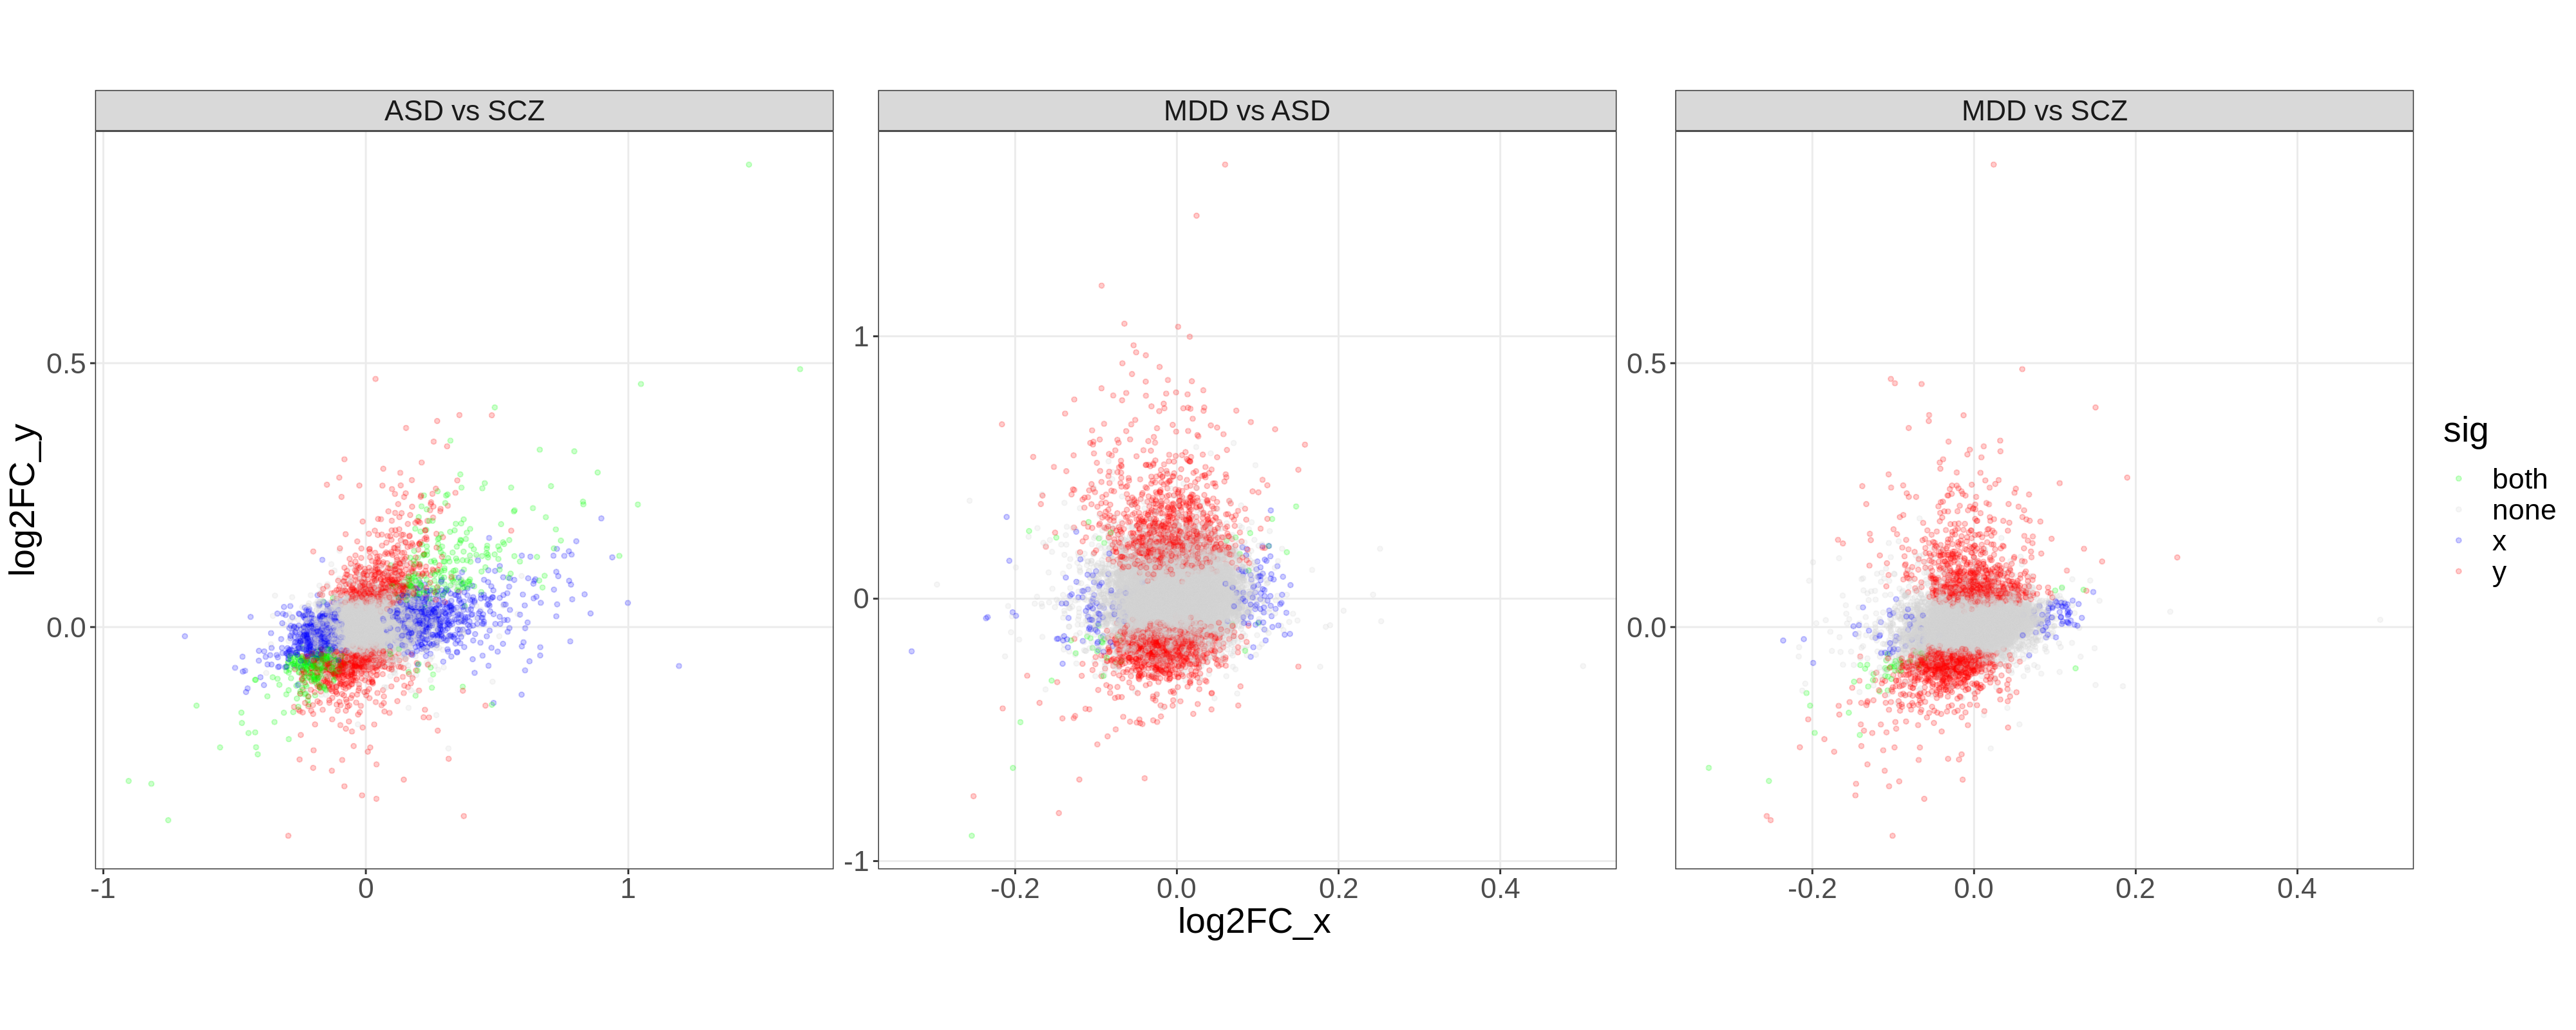

In [695]:
%%R -i gandal_overlap -w 20 -h 8 --units in -r 200
gandal_overlap %>%
mutate(name = paste(d_x,'vs',d_y)) %>%
mutate(sig = case_when(
        sig_x & sig_y ~ 'both', sig_x ~ 'x', sig_y ~ 'y', TRUE ~ 'none')
      ) %>% 
ggplot(aes(x=log2FC_x, y=log2FC_y)) + 
facet_wrap(~name, ncol=3, scales='free') +
geom_point(aes(color=sig), size=1, alpha=.2) + 
scale_color_manual(values=c('green','lightgrey','blue','red')) +
theme_bw() +
theme(
    aspect.ratio=1,
    panel.grid.minor=element_blank(),
    text=element_text(size=20)
)

In [728]:
disorders = ['ASD', 'SCZ']
for d in disorders:
    gandal_genes_rna[f'{d}.sig'] = gandal_genes_rna[f'{d}.FDR'] < .05

gandal_sig = (gandal_genes_micro
              .loc[:,[f'{d}.sig' for d in disorders]]
              .melt(ignore_index=False, var_name='d', value_name='sig')
              .assign(d = lambda x: x['d'].str.replace('.sig','', regex=False))
              .set_index('d', append=True)
             )

gandal_log2FC = (gandal_genes_micro
              .loc[:,[f'{d}.log2FC' for d in disorders]]
              .melt(ignore_index=False, var_name='d', value_name='log2FC')
              .assign(d = lambda x: x['d'].str.replace('.log2FC','', regex=False))
              .set_index('d', append=True)
              .join(gandal_sig)
              # .reset_index(1)
                 )

gandal_sig_rna = (gandal_genes_rna
              .loc[:,[f'{d}.sig' for d in disorders]]
              .melt(ignore_index=False, var_name='d', value_name='sig')
              .assign(d = lambda x: x['d'].str.replace('.sig','', regex=False))
              .set_index('d', append=True)
             )

gandal_log2FC_rna = (gandal_genes_rna
              .loc[:,[f'{d}.log2FC' for d in disorders]]
              .melt(ignore_index=False, var_name='d', value_name='log2FC')
              .assign(d = lambda x: x['d'].str.replace('.log2FC','', regex=False))
              .set_index('d', append=True)
              .join(gandal_sig_rna)
              # .reset_index(1)
                 )


gandal_compare = (gandal_log2FC
                  .join(gandal_log2FC_rna, lsuffix='_micro', rsuffix='_rna')
                  .dropna()
                  .reset_index()
                 )
gandal_compare

gene    d  log2FC_micro  sig_micro  log2FC_rna sig_rna
0              TSPAN6  ASD      0.117073      False    0.164046   False
1                TNMD  ASD      0.082085      False    0.059227   False
2                DPM1  ASD      0.004612      False    0.003448   False
3               SCYL3  ASD     -0.030065      False   -0.094801   False
4            C1orf112  ASD     -0.102755      False   -0.071735   False
...               ...  ...           ...        ...         ...     ...
24950           MILR1  SCZ     -0.015322      False   -0.208963    True
24951  RP11-152N13.16  SCZ     -0.011695      False   -0.033003   False
24952   RP11-302B13.5  SCZ     -0.062727       True    0.124363   False
24953    CTC-487M23.8  SCZ      0.014645      False    0.048725   False
24954          GRIN2B  SCZ      0.019514      False    0.016681   False

[24955 rows x 6 columns]

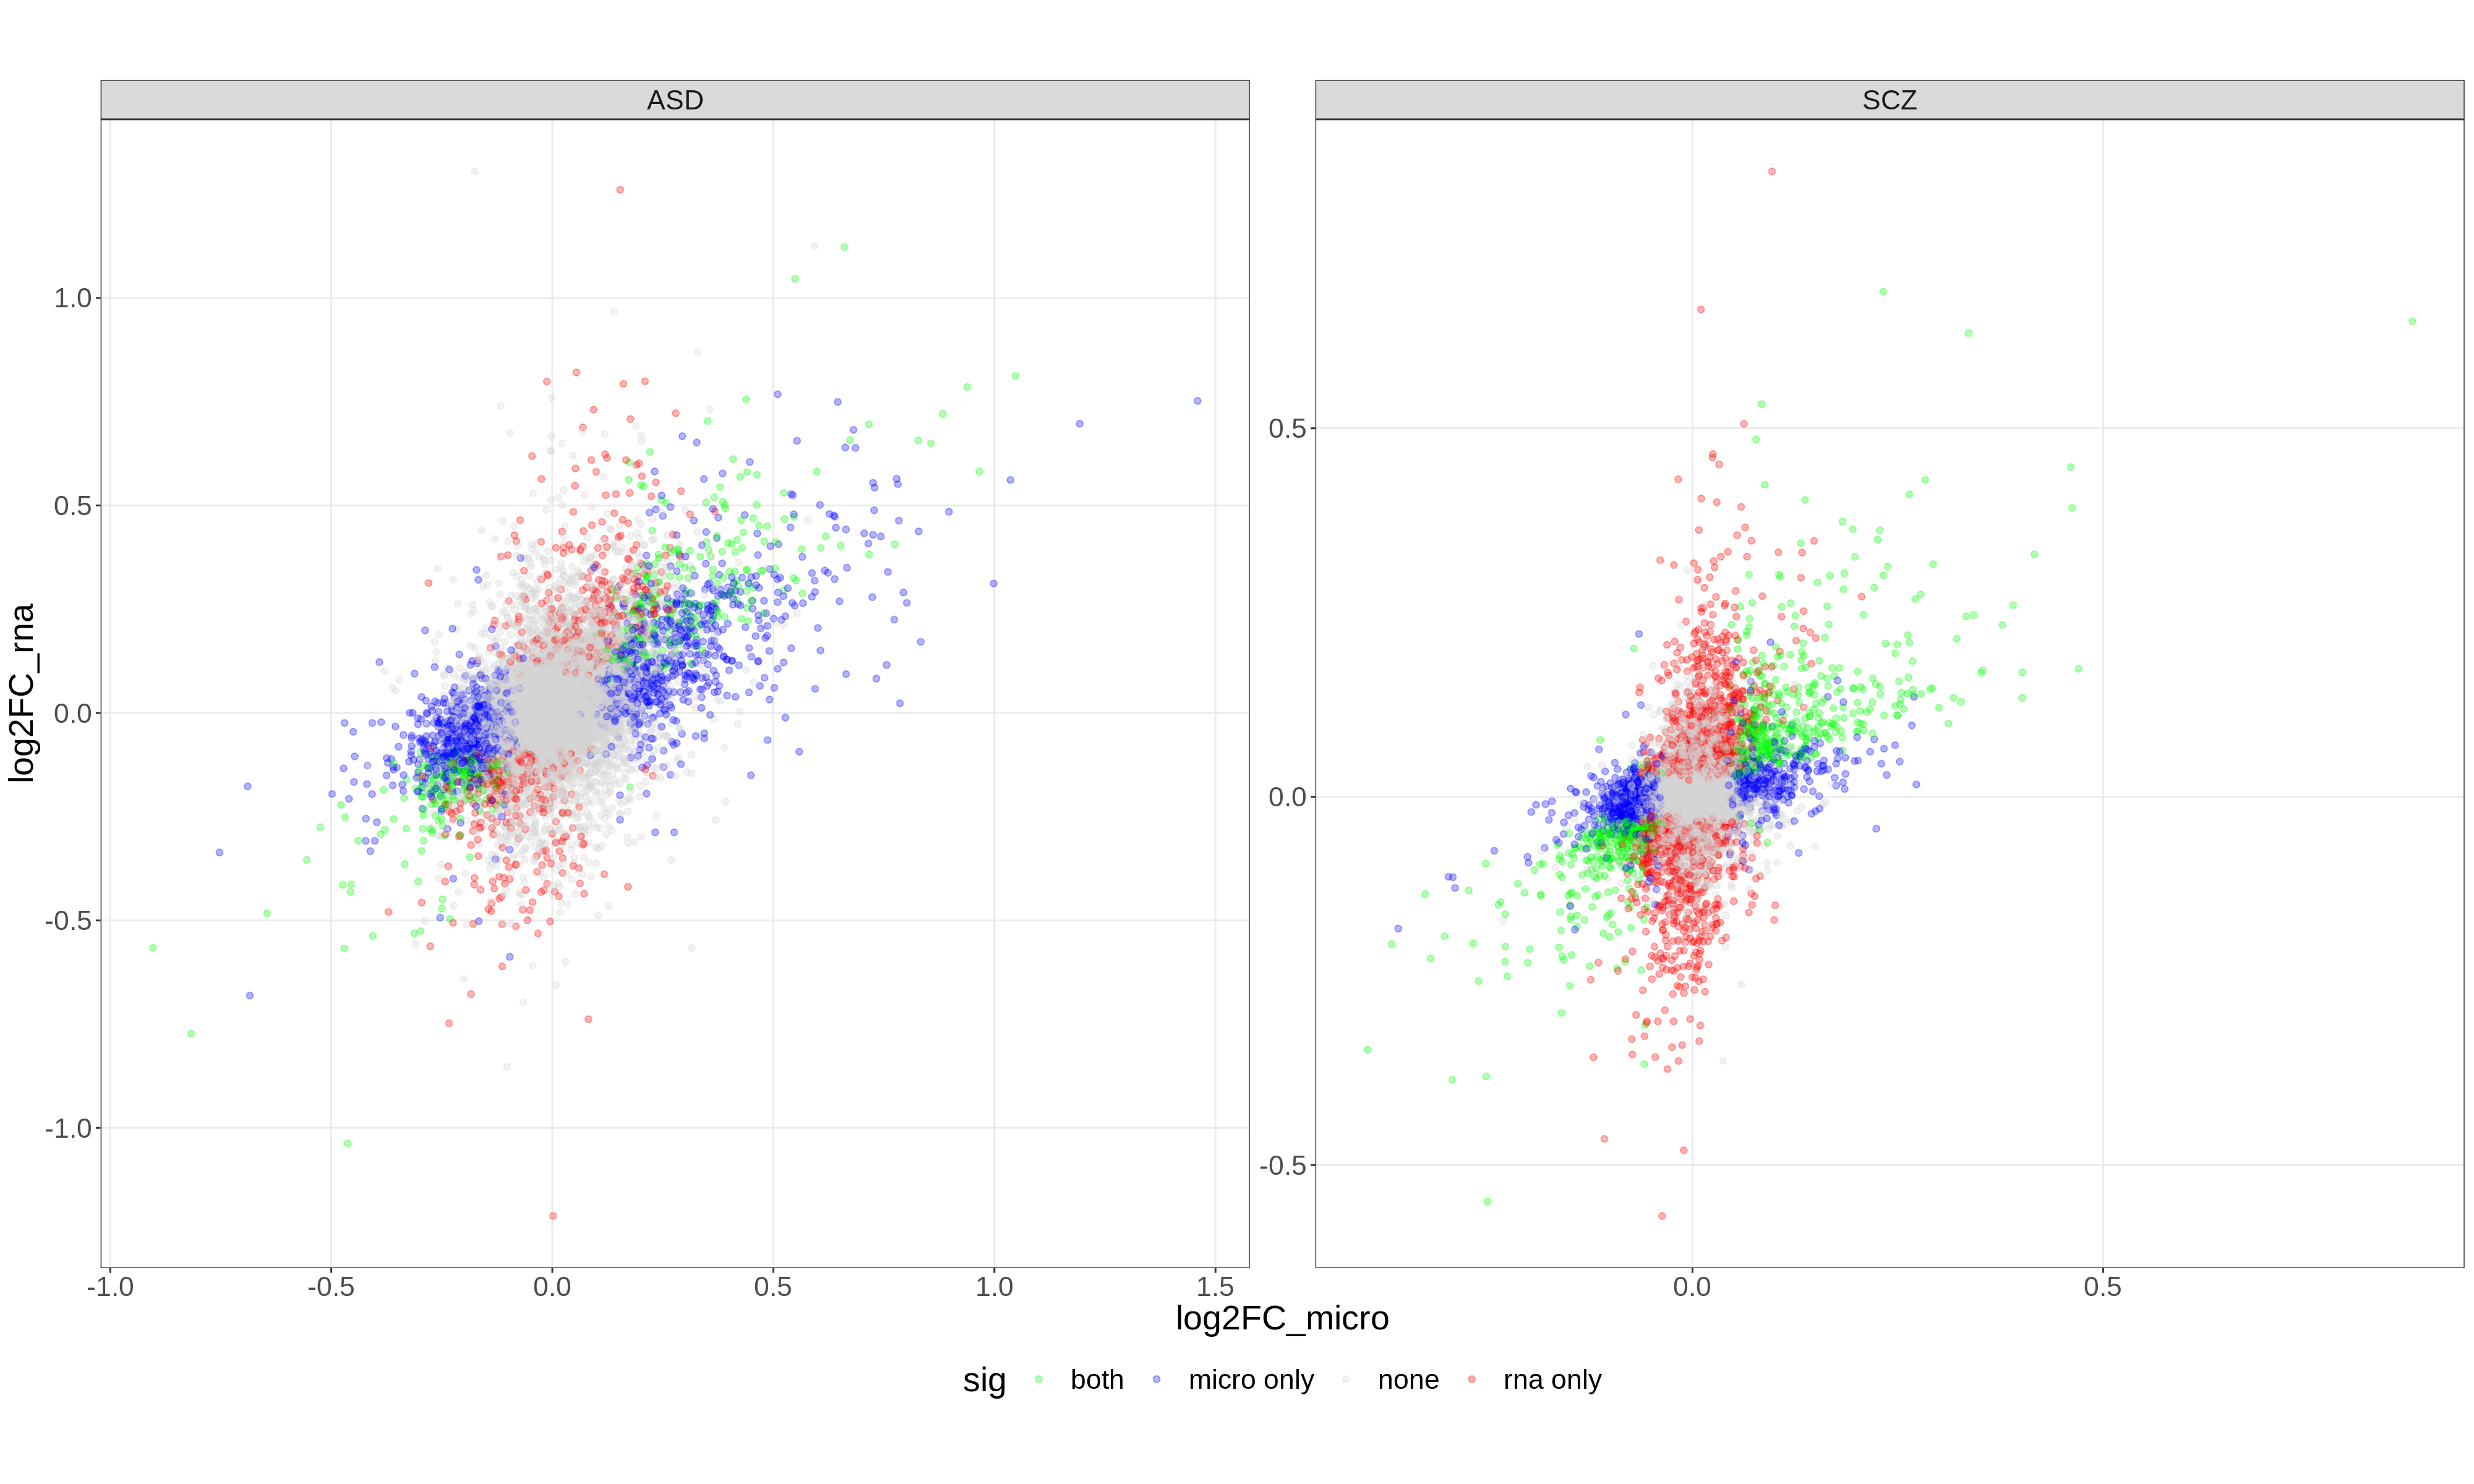

In [733]:
%%R -i gandal_compare -w 20 -h 12 --units in -r 200
gandal_compare %>%
# mutate(name = paste(d_x,'vs',d_y)) %>%
mutate(sig = case_when(
        sig_micro & sig_rna ~ 'both', sig_micro ~ 'micro only', sig_rna ~ 'rna only', TRUE ~ 'none')
      ) %>% 
ggplot(aes(x=log2FC_micro, y=log2FC_rna)) + 
facet_wrap(~d, ncol=2, scales='free') +
geom_point(aes(color=sig), size=1.5, alpha=.3) + 
scale_color_manual(values=c('green','blue','lightgrey','red')) +
theme_bw() +
theme(
    aspect.ratio=1,
    panel.grid.minor=element_blank(),
    text=element_text(size=20),
    legend.position='bottom'
)

In [758]:

weights_melt = weights.set_axis(['G1','G2','G3'],axis=1).stack().rename('weight').to_frame().rename_axis(['gene','G']).reset_index(1)

fdr_melt = (gandal_genes_micro
 .loc[:, [f'{d}.FDR' for d in ['ASD','MDD','SCZ']]]
 .rename({f'{d}.FDR':d for d in ['ASD','MDD','SCZ']},axis=1)
 .stack().rename('FDR').to_frame()
 .rename_axis(['gene','disorder'])
 .assign(sig = lambda x: x['FDR']<.05)
)

dge_melt = (gandal_genes_micro
 .loc[:, [f'{d}.log2FC' for d in ['ASD','MDD','SCZ']]]
 .rename({f'{d}.log2FC':d for d in ['ASD','MDD','SCZ']},axis=1)
 .stack().rename('log2FC').to_frame()
 .rename_axis(['gene','disorder'])
 .join(fdr_melt)
 .reset_index(1)
)


df_weights_dge = weights_melt.join(dge_melt).reset_index().dropna()

In [765]:
genes_sig = df_weights_dge.query("sig==True")
ASD_genes = genes_sig.loc[lambda x: x['disorder'] == 'ASD', 'gene']
SCZ_genes = genes_sig.loc[lambda x: x['disorder'] == 'SCZ', 'gene']
intersection = set(ASD_genes).intersection(SCZ_genes)

df_weights_dge = (df_weights_dge
                  .assign(both_sig = lambda x: np.isin(x['gene'], list(intersection)))
                 )

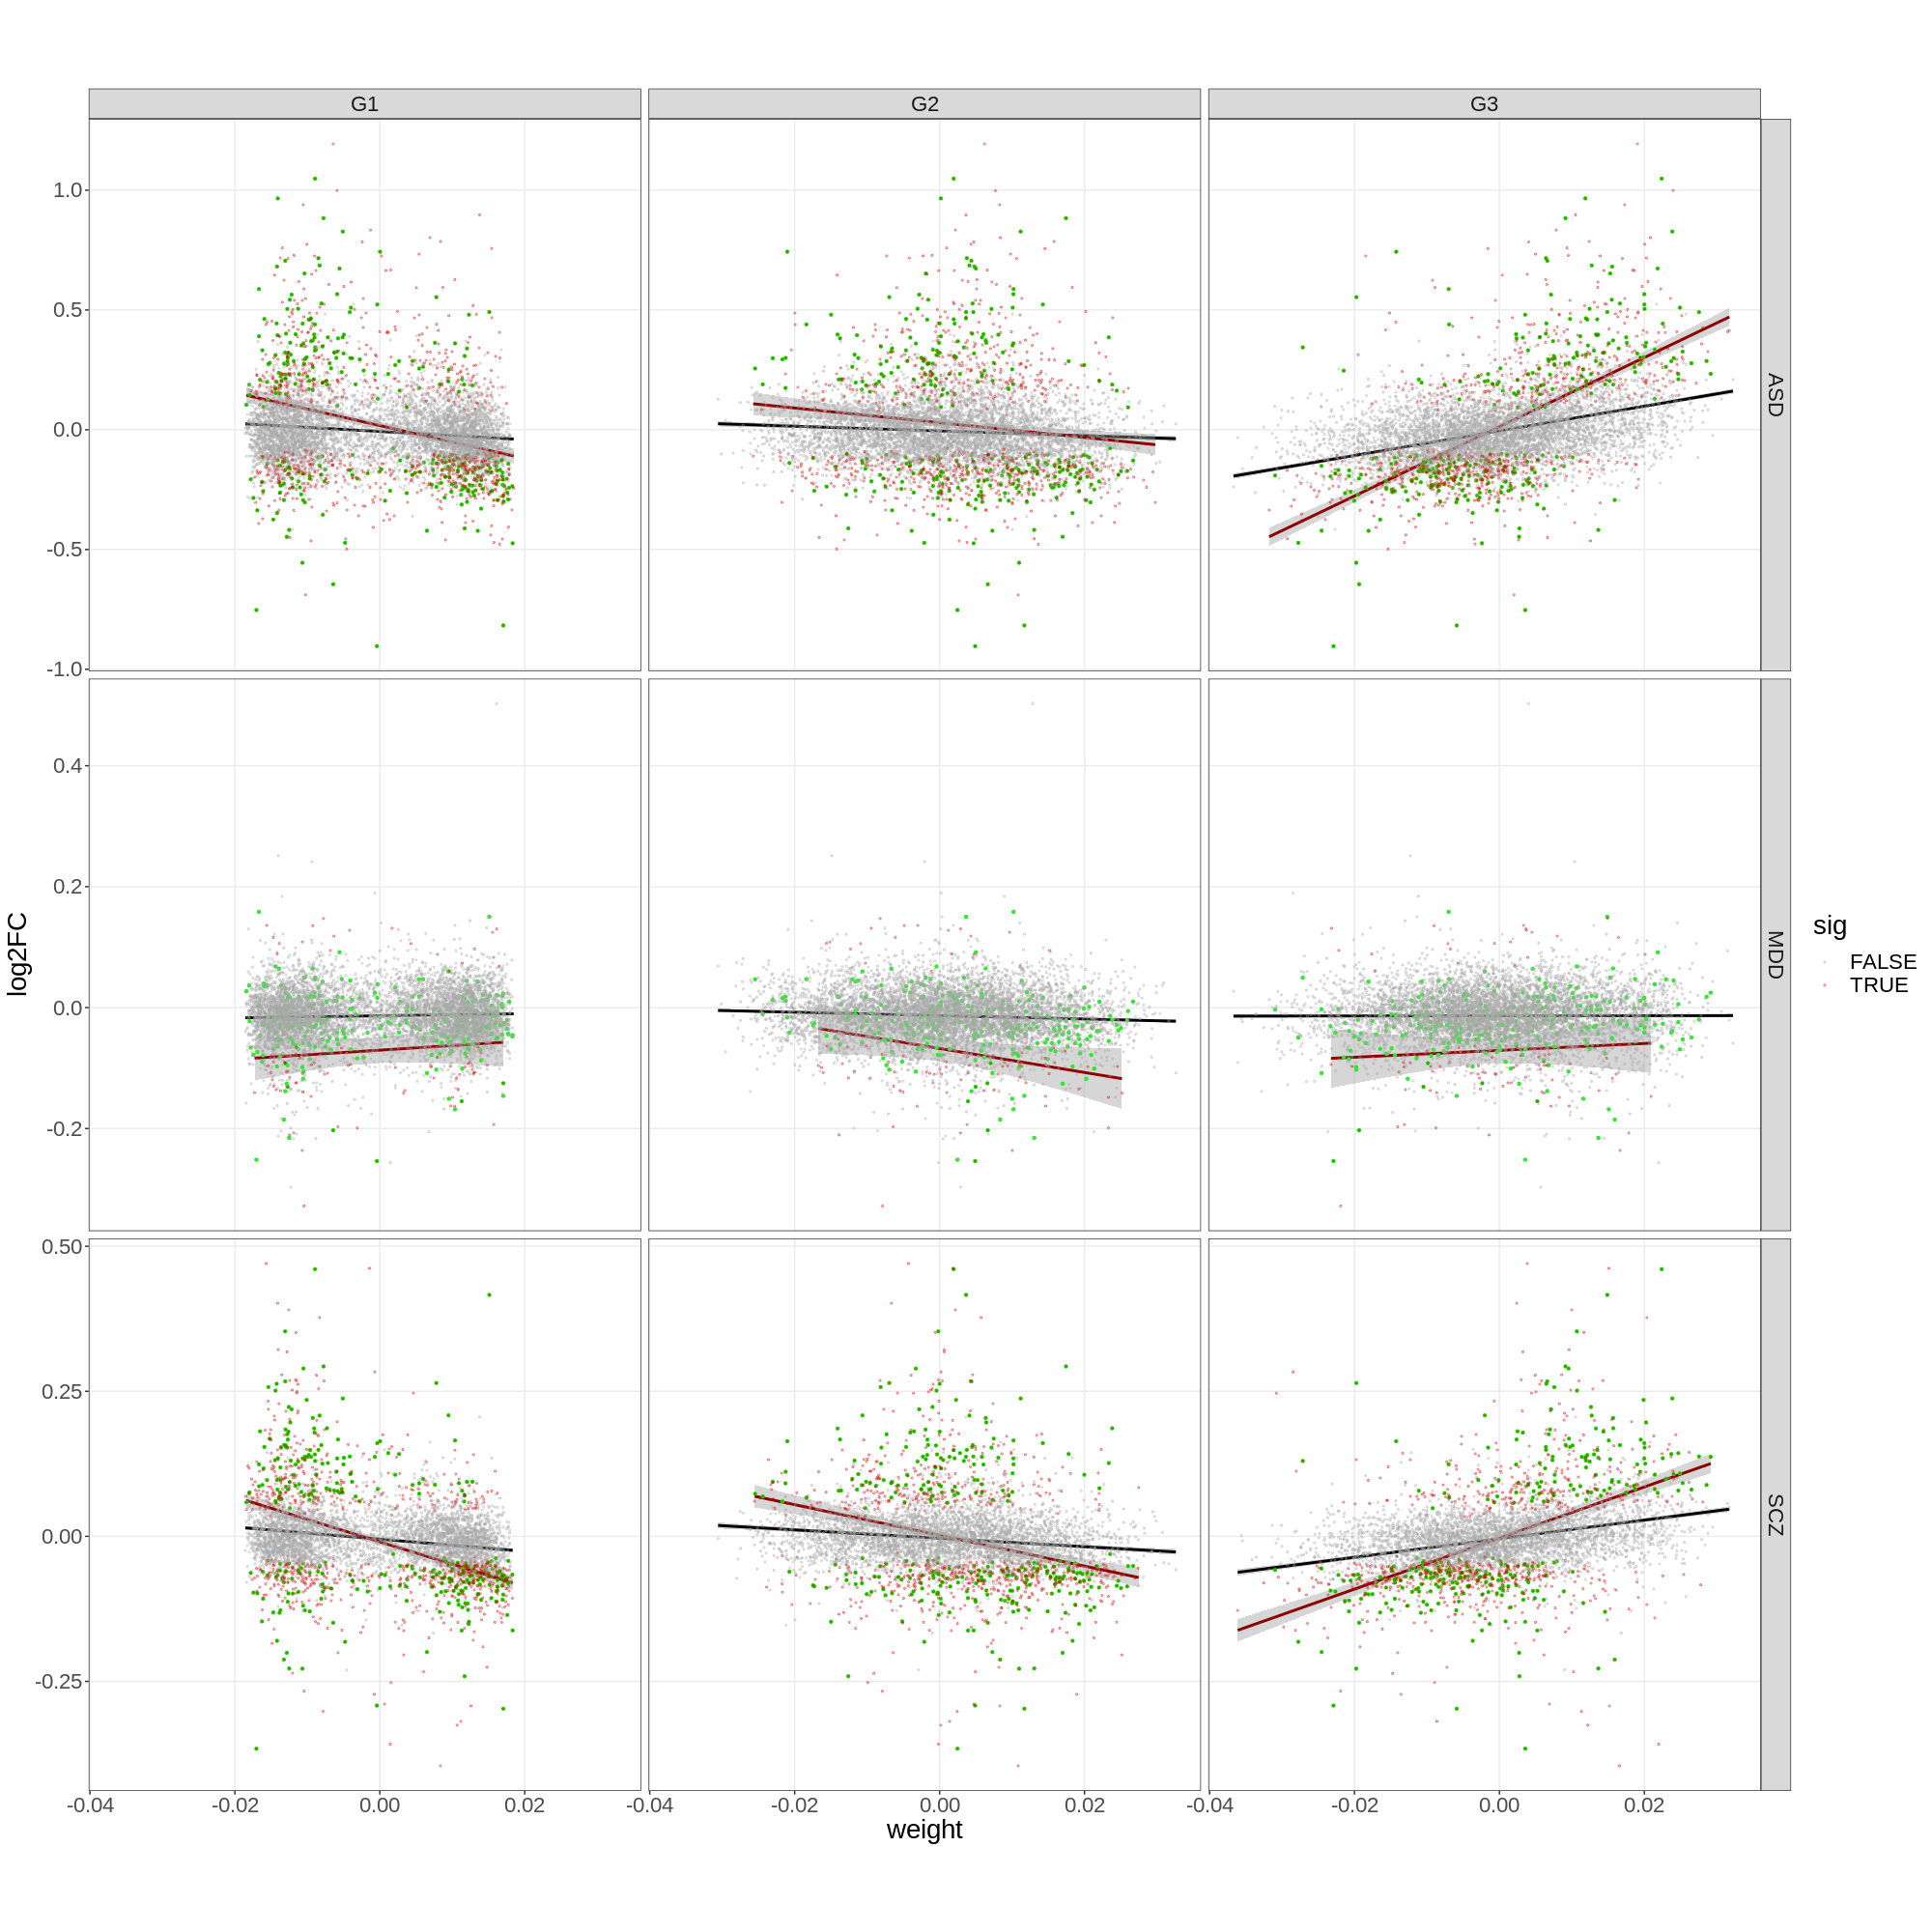

In [768]:
%%R -i df_weights_dge -w 20 -h 20 --units in -r 100
df_weights_dge %>%
ggplot(aes(x=weight, y=log2FC)) + 
facet_grid(disorder~G, scales='free_y') +
geom_smooth(method='lm', color='black') +
geom_smooth(method='lm', color='darkred', data = df_weights_dge %>% filter(sig)) +
geom_point(color='green', alpha=1, size=.8, data=df_weights_dge %>% filter(both_sig)) +
geom_point(aes(color=sig), alpha=.3, size=.5) +
scale_color_manual(values=c('darkgrey','red3')) +
# scale_color_gradientn(colors=rev(brewer.blues(100))) + 
# scale_alpha_manual(values=c(.2,1)) + 
theme_bw() +
theme(
    aspect.ratio=1,
    panel.grid.minor=element_blank(),
    text=element_text(size=20)
)

In [753]:
gandal_genes = gandal_genes_rna
disorders = ['ASD','SCZ']

weights_melt = weights.set_axis(['G1','G2','G3'],axis=1).stack().rename('weight').to_frame().rename_axis(['gene','G']).reset_index(1)

fdr_melt = (gandal_genes_rna
 .loc[:, [f'{d}.FDR' for d in disorders]]
 .rename({f'{d}.FDR':d for d in disorders},axis=1)
 .stack().rename('FDR').to_frame()
 .rename_axis(['gene','disorder'])
 .assign(sig = lambda x: x['FDR']<.05)
)

dge_melt = (gandal_genes_rna
 .loc[:, [f'{d}.log2FC' for d in disorders]]
 .rename({f'{d}.log2FC':d for d in disorders},axis=1)
 .stack().rename('log2FC').to_frame()
 .rename_axis(['gene','disorder'])
 .join(fdr_melt)
 .reset_index(1)
)


df_weights_dge = weights_melt.join(dge_melt).reset_index().dropna()

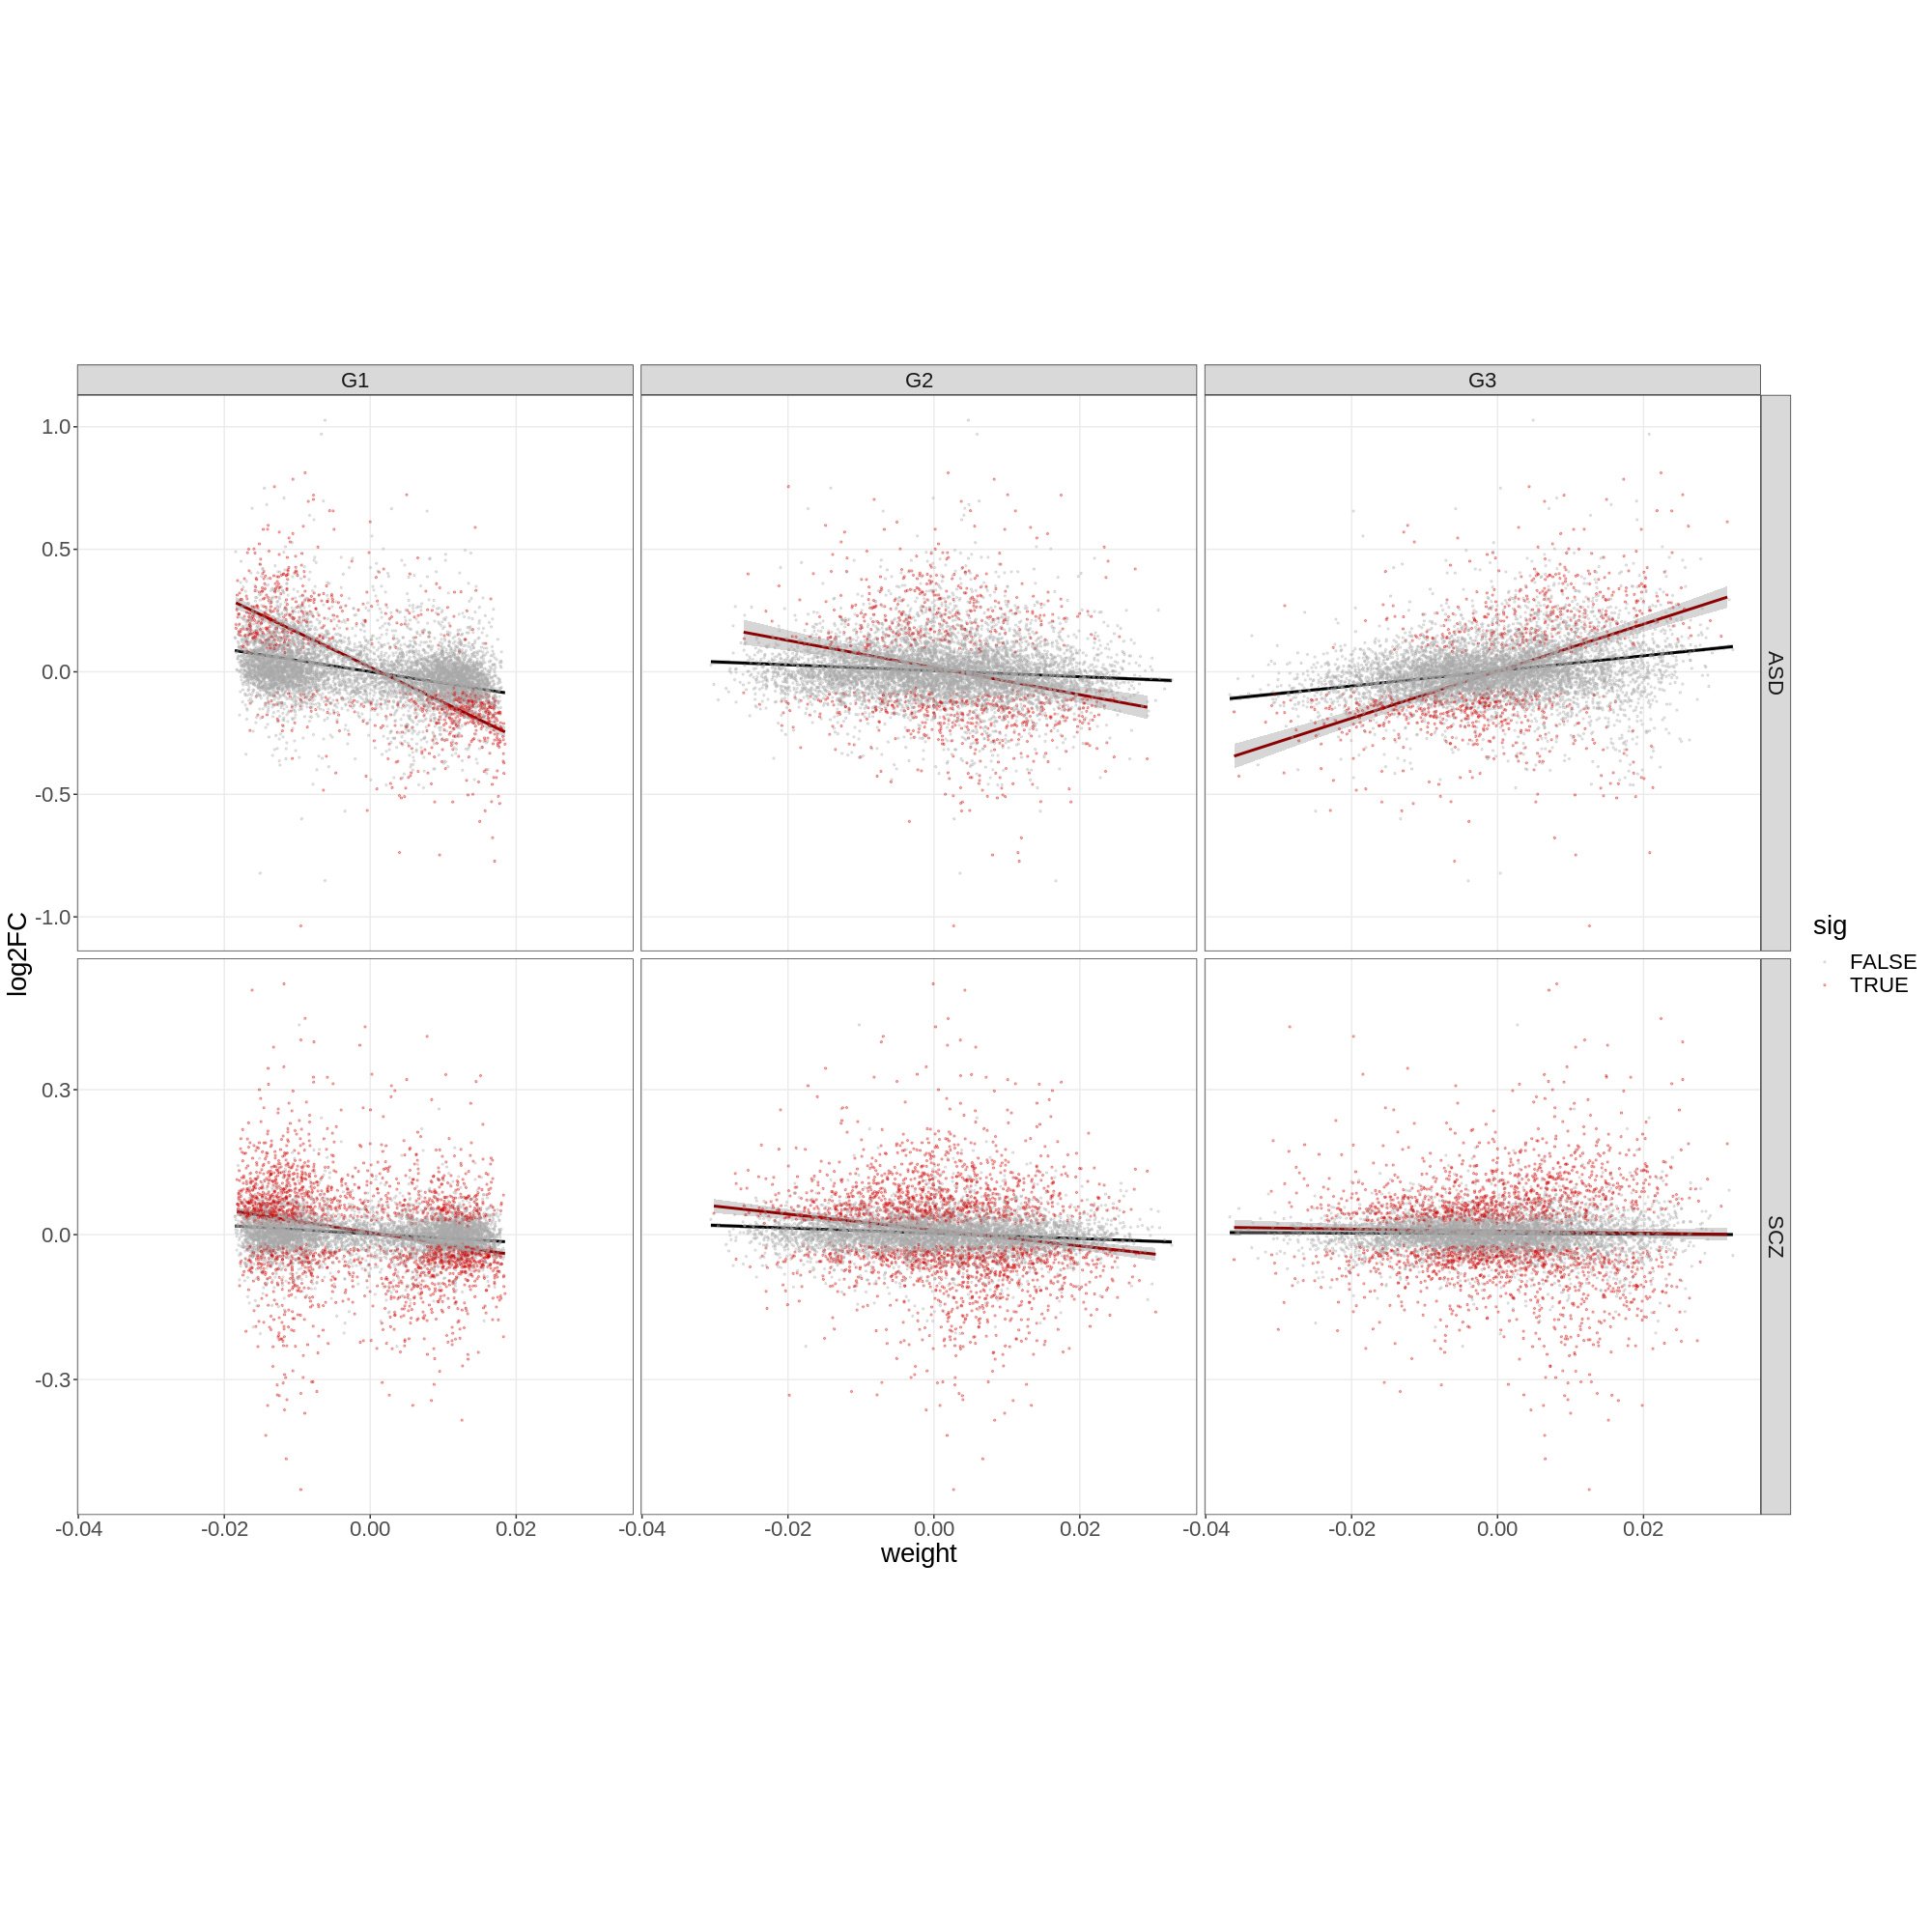

In [755]:
%%R -i df_weights_dge -w 20 -h 20 --units in -r 100
df_weights_dge %>%
ggplot(aes(x=weight, y=log2FC)) + 
facet_grid(disorder~G, scales='free_y') +
geom_smooth(method='lm', color='black') +
geom_smooth(method='lm', color='darkred', data = df_weights_dge %>% filter(sig)) +
geom_point(aes(color=sig), alpha=.3, size=.5) +
scale_color_manual(values=c('darkgrey','red3')) +
# scale_color_gradientn(colors=rev(brewer.blues(100))) + 
# scale_alpha_manual(values=c(.2,1)) + 
theme_bw() +
theme(
    aspect.ratio=1,
    panel.grid.minor=element_blank(),
    text=element_text(size=20)
)

## Correlations

In [801]:
gandal_genes = gandal_genes_micro
# null_weights = null_weights_sim

In [802]:
null_p_versions_dict = {    
    'Gene Corr (Random)': get_gene_corr(weights, null_weights_shuffle, gandal_genes),
    # 'Gene Corr (Sim PLS)': get_gene_corr(weights, null_weights_sim, gandal_genes),
    'Sig Gene Corr (Random)': get_gene_corr(weights, null_weights_shuffle, gandal_genes, sig_thresh=.05),
    # 'Sig Gene Corr (Sim PLS)': get_gene_corr(weights, null_weights_sim, gandal_genes, sig_thresh=.05), 
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

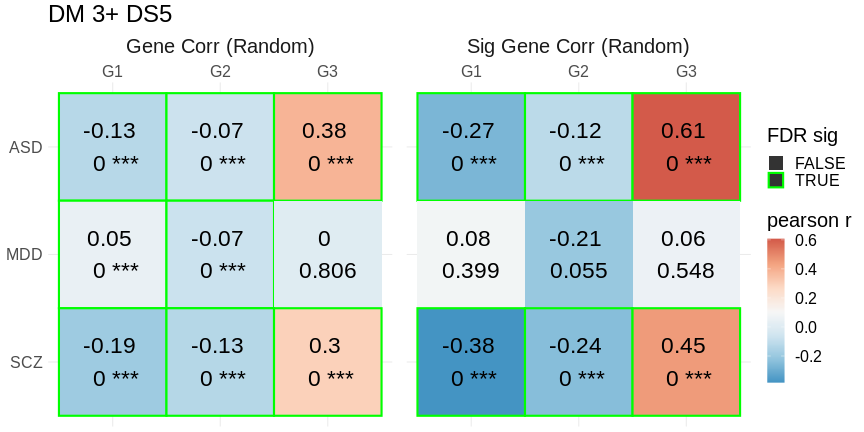

In [803]:
%%R -w 12 -h 6 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2) + ggtitle('DM 3+ DS5')

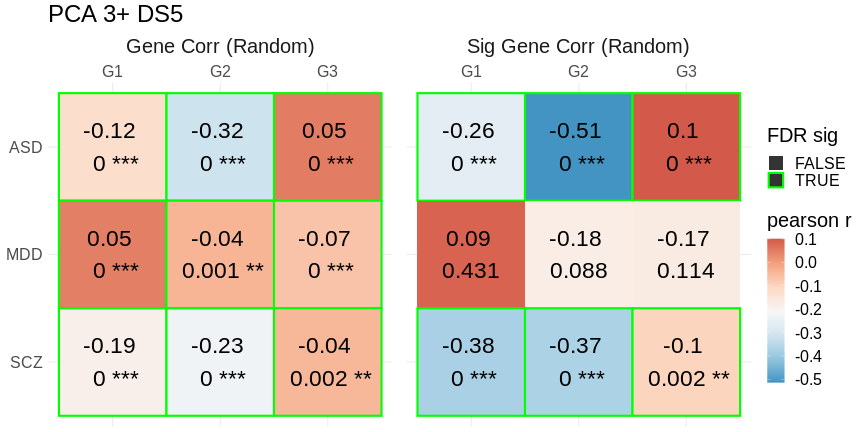

In [797]:
%%R -w 12 -h 6 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2) + ggtitle('PCA 3+ DS5')

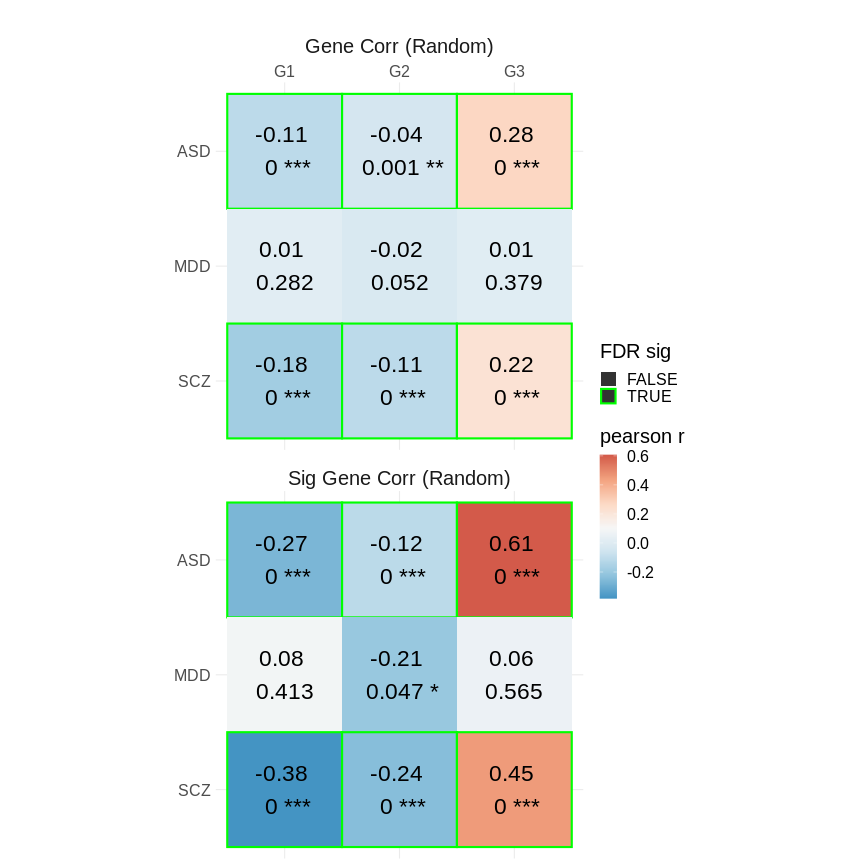

In [639]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=1) + ggtitle('')

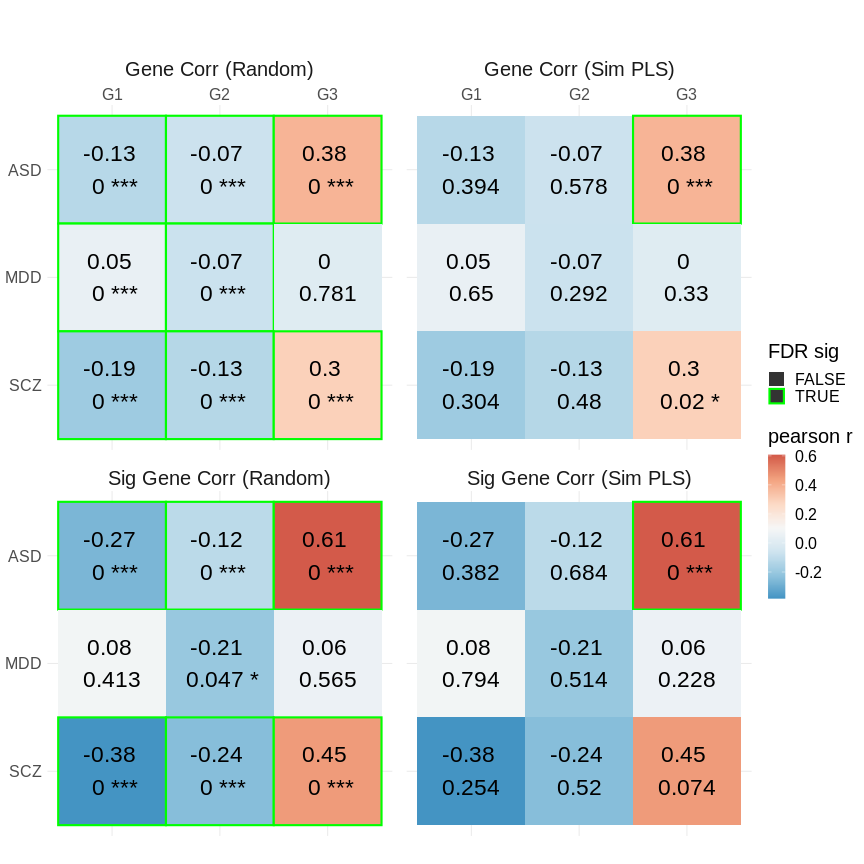

In [546]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2) + ggtitle('')

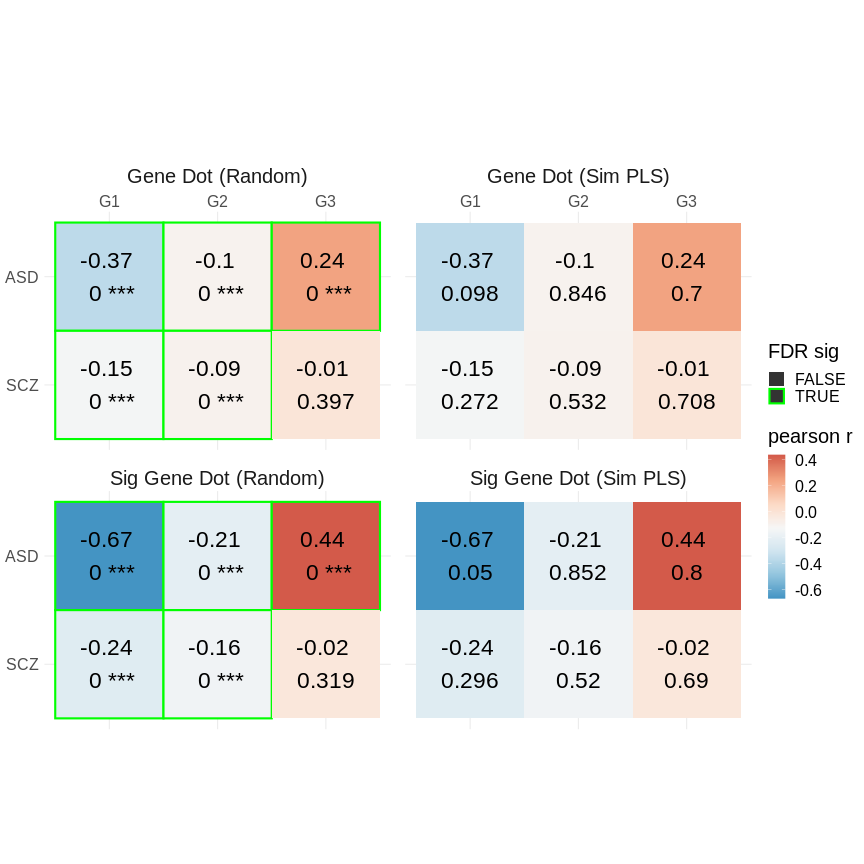

In [534]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2) + ggtitle('')

In [472]:
null_p_versions_dict['Microarray Sig Gene Corrs']

label   G    pct  true_mean  null_mean  null_std         z    pos      p  \
0   ASD  G1  0.025  -0.667938  -0.347901  0.290061 -1.103342  False  0.050   
1   ASD  G2  0.426  -0.213011  -0.031912  0.449658 -0.402748  False  0.852   
2   ASD  G3  0.600   0.435972   0.178996  0.408545  0.629004   True  0.800   
3   SCZ  G1  0.148  -0.239962  -0.115417  0.121123 -1.028251  False  0.296   
4   SCZ  G2  0.260  -0.158154  -0.025789  0.165849 -0.798108  False  0.520   
5   SCZ  G3  0.345  -0.021806   0.042780  0.162465 -0.397539  False  0.690   

       q    sig  
0  0.300  False  
1  0.852  False  
2  0.852  False  
3  0.852  False  
4  0.852  False  
5  0.852  False

## Dot products

In [539]:
gandal_genes = gandal_genes_rna

In [540]:
null_p_versions_dict = {
    'Gene Dot (Random)': get_gene_dot(weights, null_weights_shuffle, gandal_genes),
    'Gene Dot (Sim PLS)': get_gene_dot(weights, null_weights_sim, gandal_genes),
    'Sig Gene Dot (Random)': get_gene_dot(weights, null_weights_shuffle, gandal_genes, sig_thresh=.05),
    'Sig Gene Dot (Sim PLS)': get_gene_dot(weights, null_weights_sim, gandal_genes, sig_thresh=.05), 
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

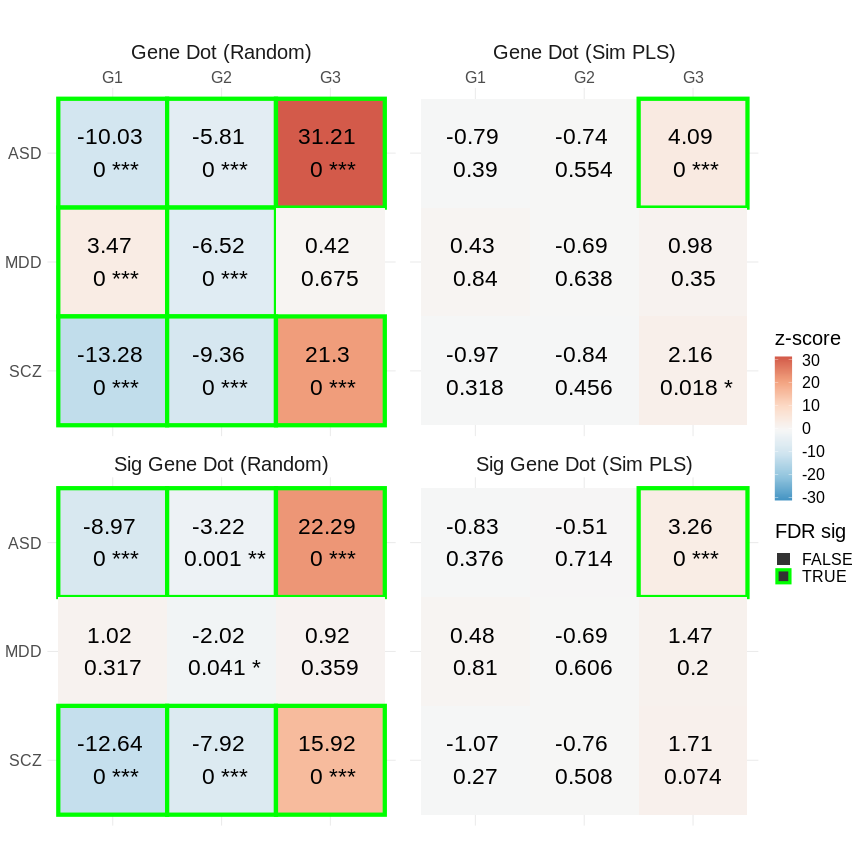

In [538]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) 
                         # fill_name='dot') + ggtitle('')

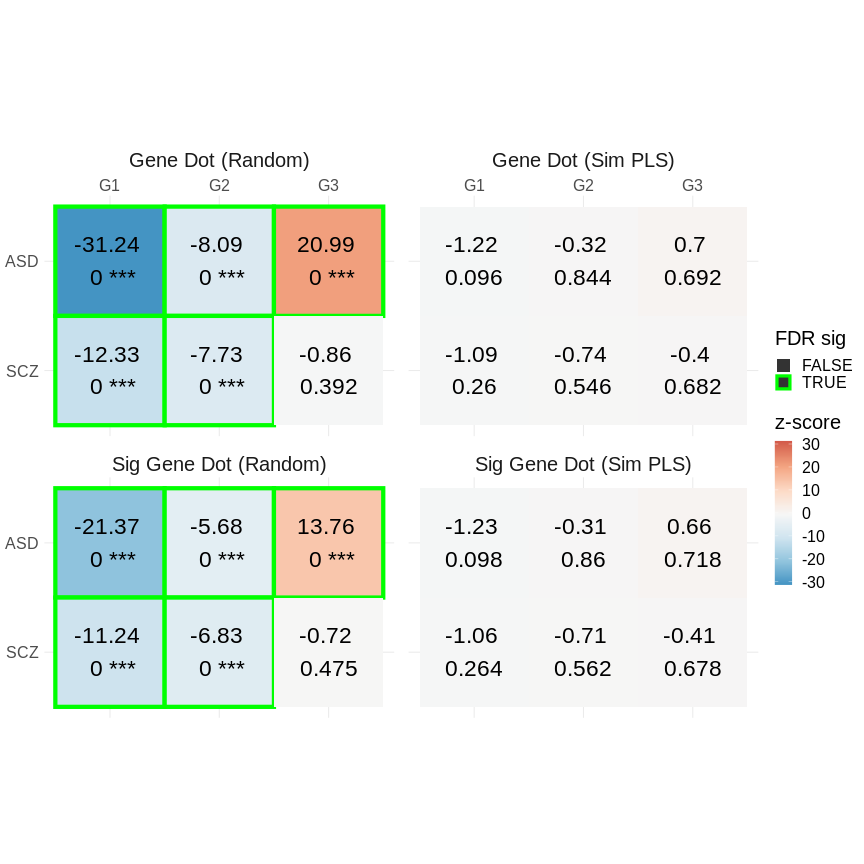

In [541]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) 
                         # fill_name='dot') + ggtitle('')

## Maps 

In [640]:
gene_maps_dict = {
    # 'Up-reg Genes': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='pos', return_maps=True),
    # 'Dn-reg Genes': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='neg', return_maps=True),
    'Up-reg Sig Genes': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='pos', sig_thresh=.05, return_maps=True),
    'Dn-reg Sig Genes': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='neg', sig_thresh=.05, return_maps=True)
}

gene_maps_plot = (pd.concat(gene_maps_dict)
                  .reset_index()
                  .rename({'level_0':'version'},axis=1)
)

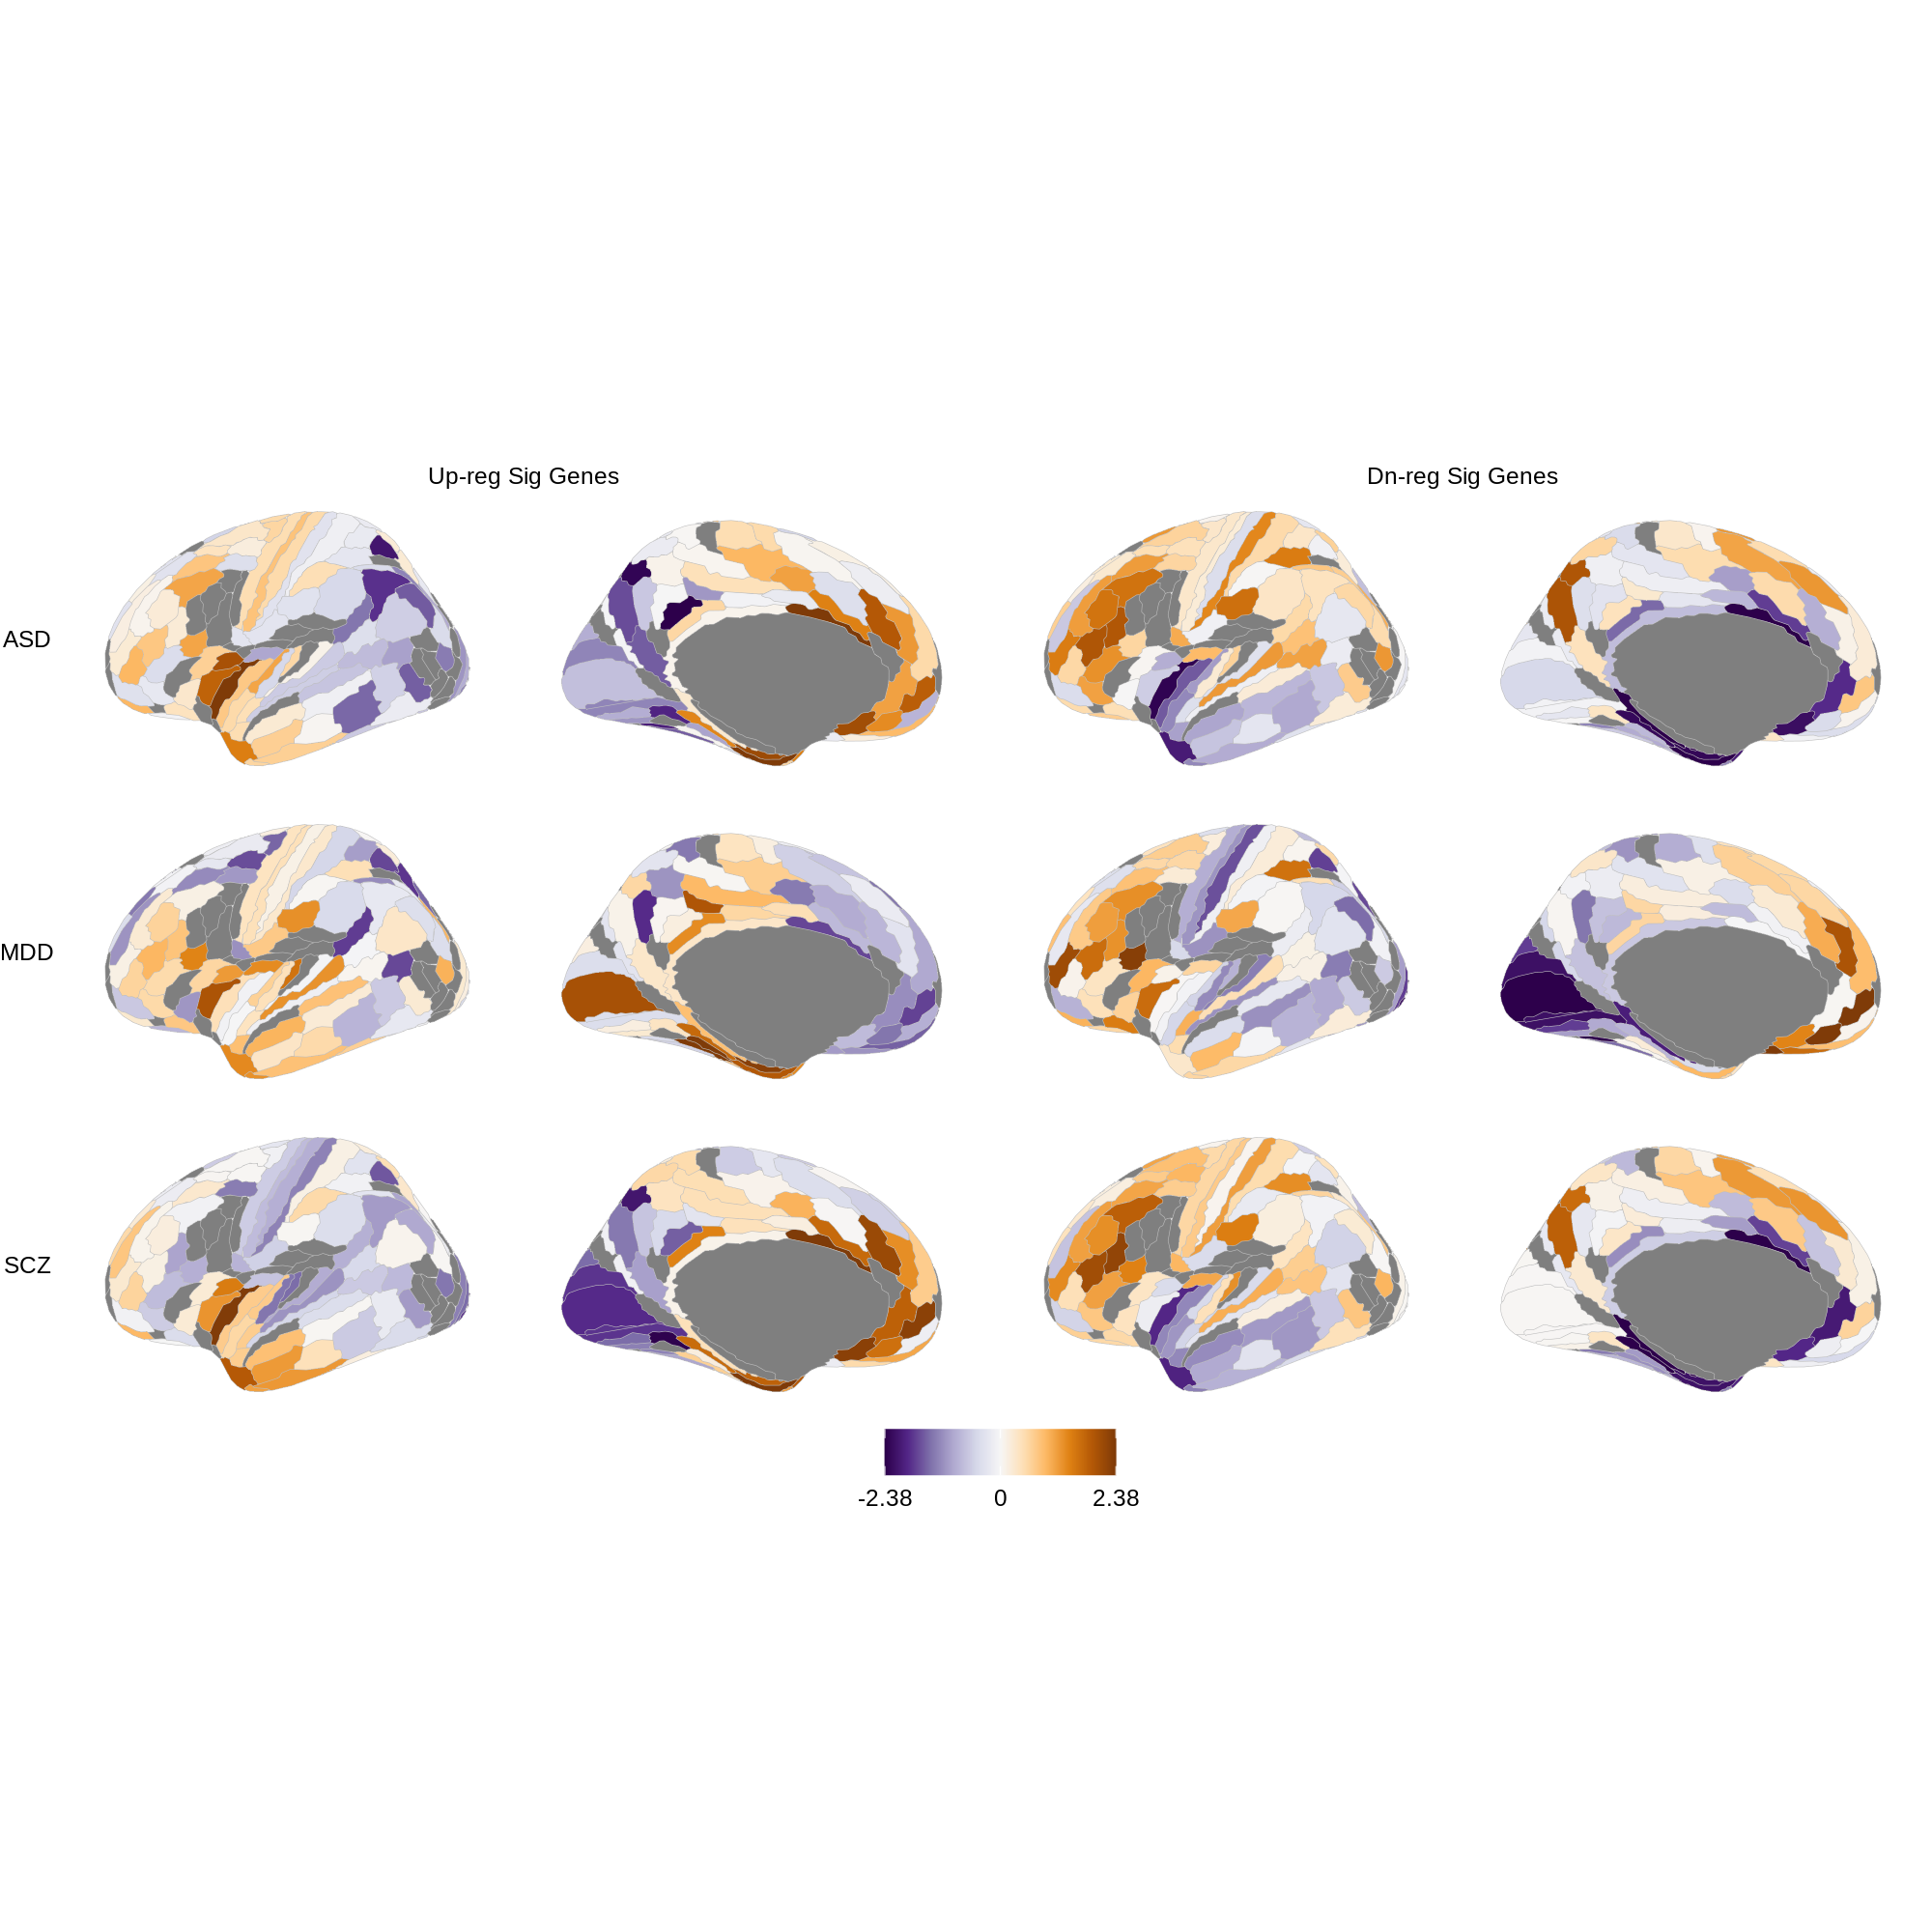

In [642]:
%%R -i gene_maps_plot -i scores -w 10 -h 10 --units in -r 200
source("../code/brainPlots.R")
# g1 <- plot_hcp(scores %>% mutate(version=''), switch='y')
# g2 <- plot_hcp(gene_maps_plot %>% filter(!grepl('Sig', version)), colors=rev(brewer.puor(100)), switch='y', facet='h')
# g2a <- plot_hcp(gene_maps_plot %>% filter(grepl('Sig', version)), colors=rev(brewer.puor(100)), switch='y', facet='h')
# (g2 / g2a) & theme(legend.position='right')
g2a

# g1 / g2 #+ plot_layout(widths=c(1,2))

In [644]:
null_scores = null_scores_sim
null_p_versions_dict = {    
    # 'Up-reg Genes': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='pos'),
    # 'Dn-reg Genes': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='neg'),
    'Up-reg Sig Genes': get_gene_map_corr(version, null_scores_spin, gandal_genes_micro, posneg='pos', sig_thresh=.05),
    'Dn-reg Sig Genes': get_gene_map_corr(version, null_scores_spin, gandal_genes_micro, posneg='neg', sig_thresh=.05)
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

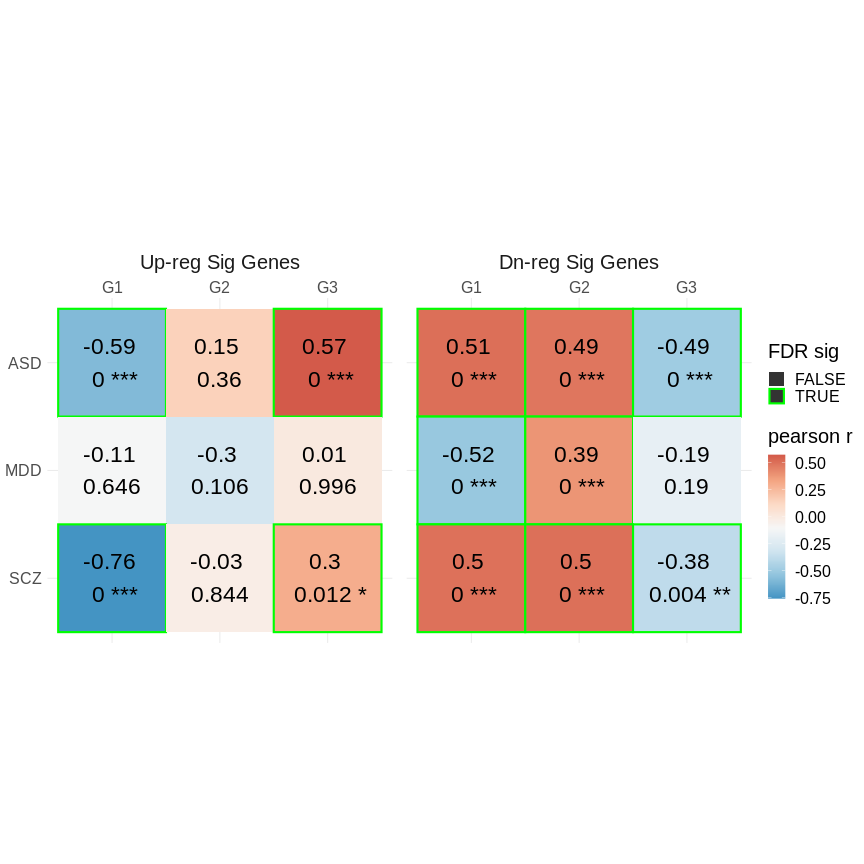

In [645]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2) + ggtitle('')

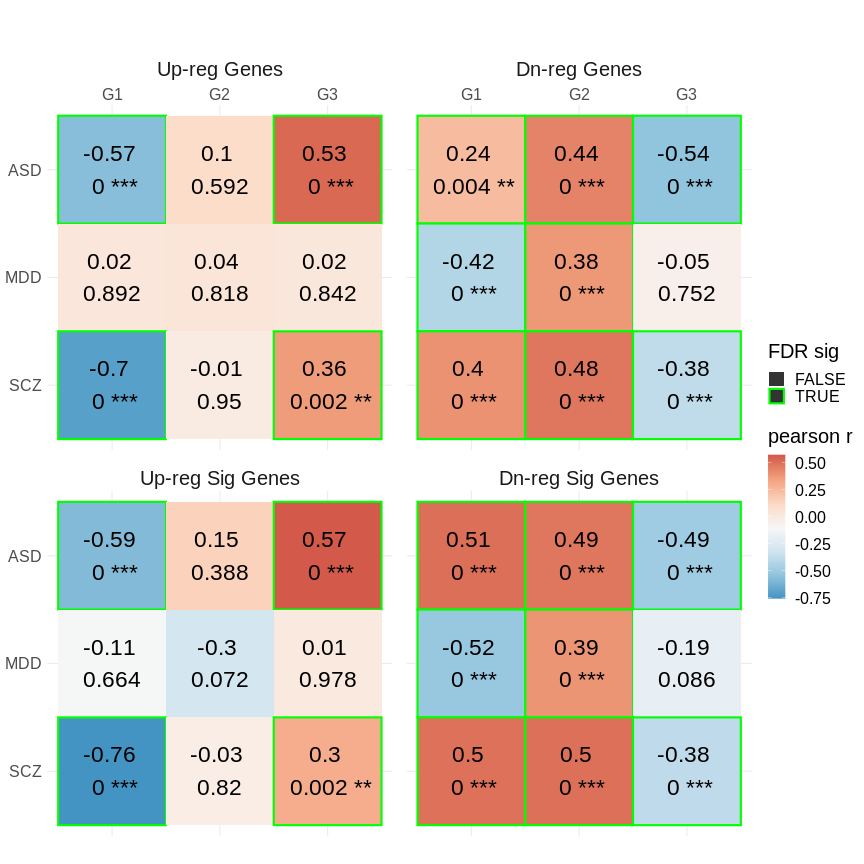

In [584]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2) + ggtitle('')

In [152]:
gene_maps_dict = {
    'Microarray': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='', sig_thresh=.05, return_maps=True),    
    'RNAseq': get_gene_map_corr(version, null_scores, gandal_genes_rna, posneg='', sig_thresh=.05, return_maps=True)
}

gene_maps_plot = (pd.concat(gene_maps_dict)
                  .reset_index()
                  .rename({'level_0':'version'},axis=1)
)

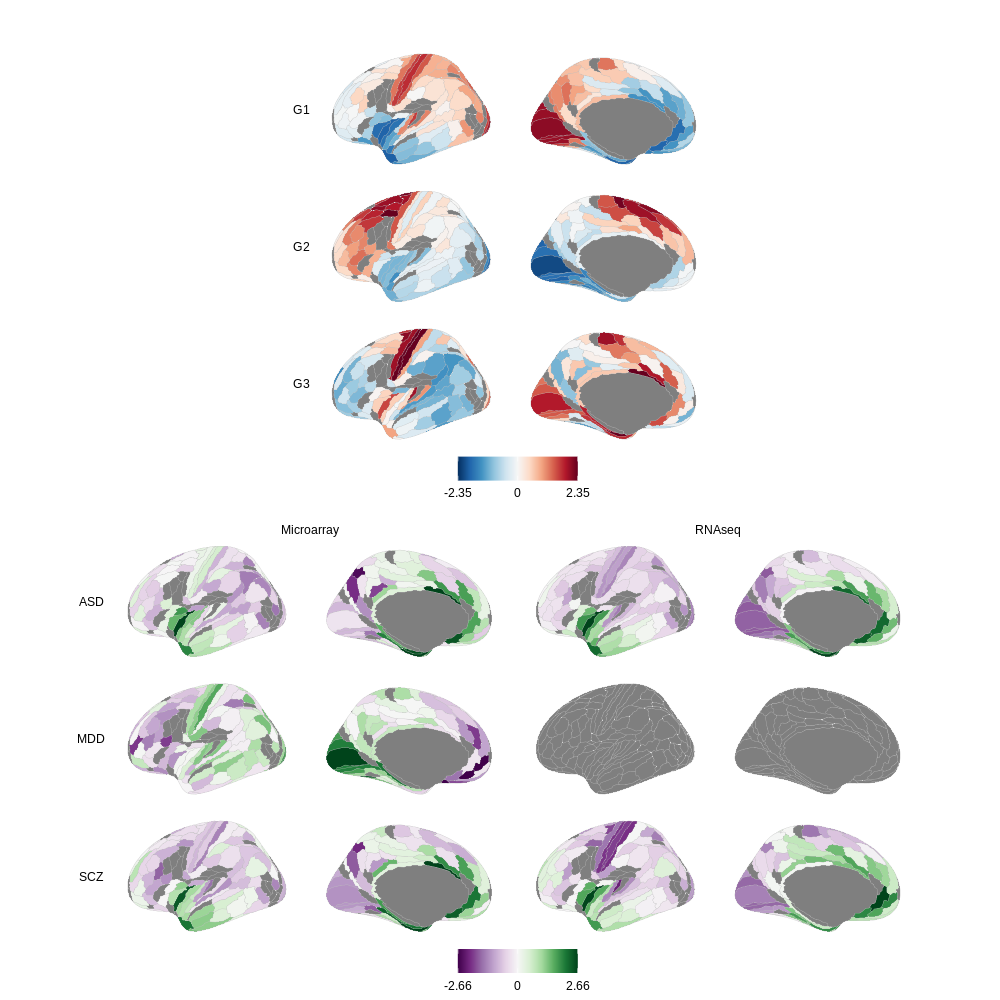

In [153]:
%%R -i gene_maps_plot -i scores -w 10 -h 10 --units in -r 100
source("../code/brainPlots.R")
g1 <- plot_hcp(scores %>% mutate(version=''), switch='y')
g2 <- plot_hcp(gene_maps_plot, colors=brewer.prgn(100), switch='y')

g1 / g2 #+ plot_layout(widths=c(1,2))

In [39]:
null_p_versions_dict = {
    'Microarray Map Corrs': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='', sig_thresh=.05),    
    'RNAseq Map Corrs': get_gene_map_corr(version, null_scores, gandal_genes_rna, posneg='', sig_thresh=.05),    
    'Microarray Gene Corrs': get_gene_corr(weights, null_weights, gandal_genes_micro, sig_thresh=.05),
    'RNAseq Gene Corrs': get_gene_corr(weights, null_weights, gandal_genes_rna, sig_thresh=.05)    
    
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

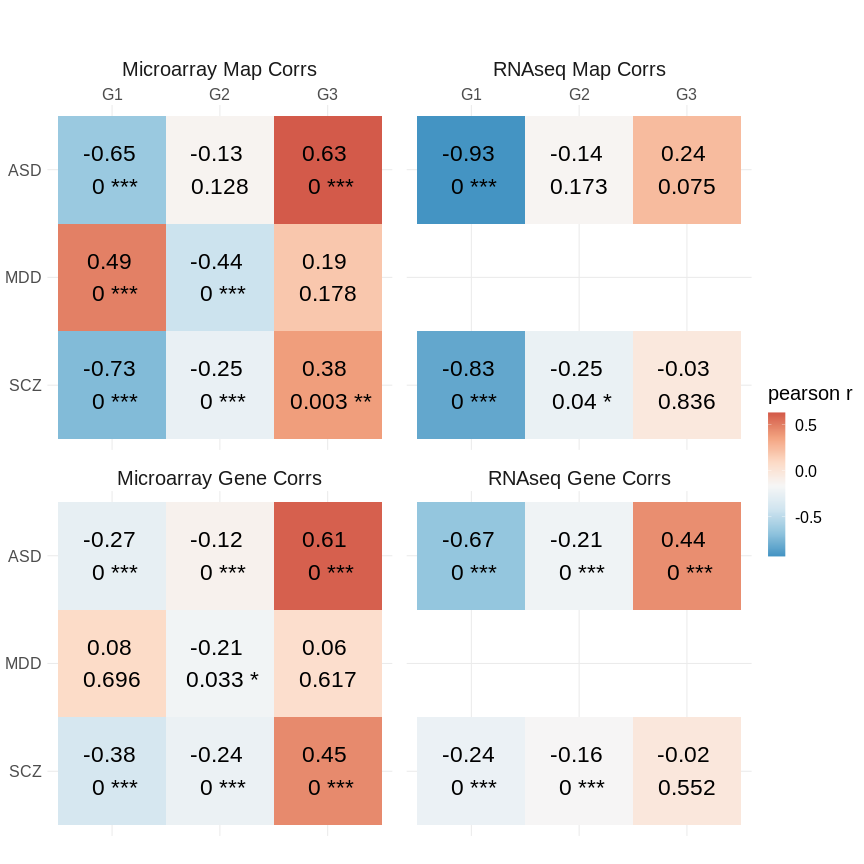

In [155]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps_2(null_p_versions, ncol=2) + ggtitle('')

In [634]:
null_weights = null_weights_shuffle[:,:,:5000]

In [782]:
null_p_versions_dict = {
    'Sig Upreg Genes, Pos Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='pos'),
    'Sig Upreg Genes, Neg Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='neg'),
    'Sig Dnreg Genes, Pos Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='pos'),
    'Sig Dnreg Genes, Neg Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='neg')
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

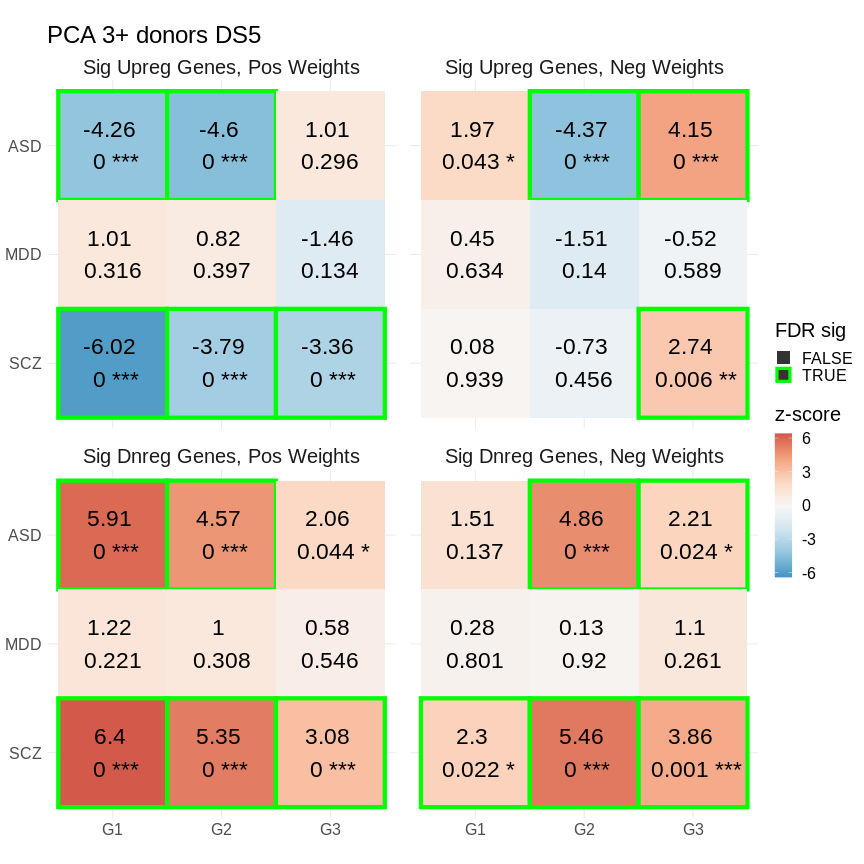

In [783]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('PCA 3+ donors DS5')

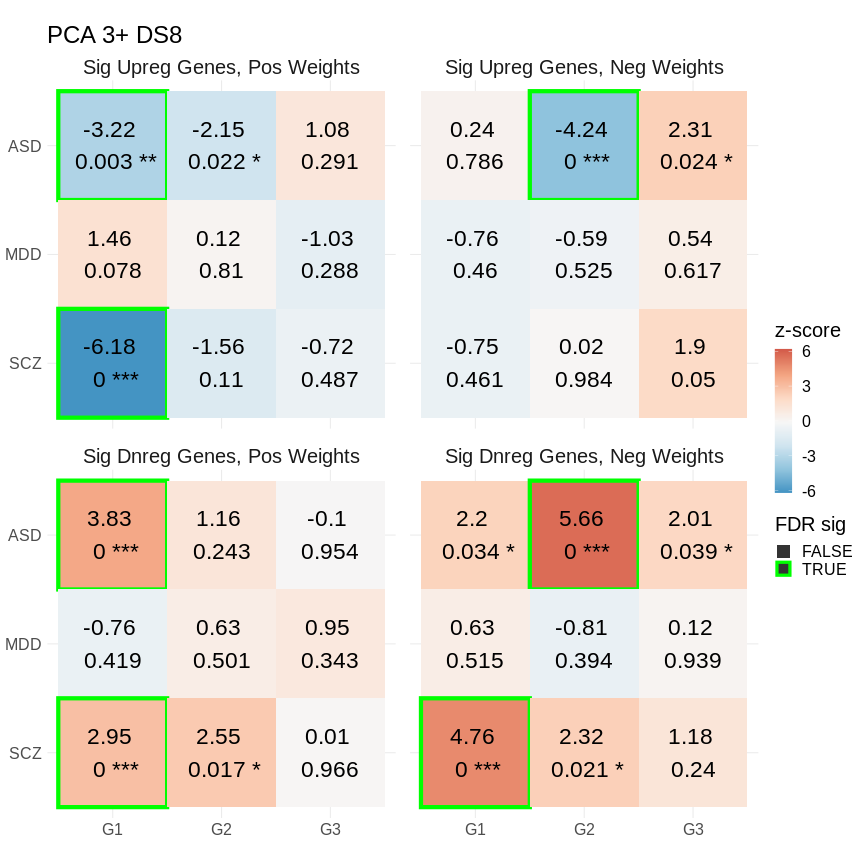

In [777]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('PCA 3+ donors DS8')

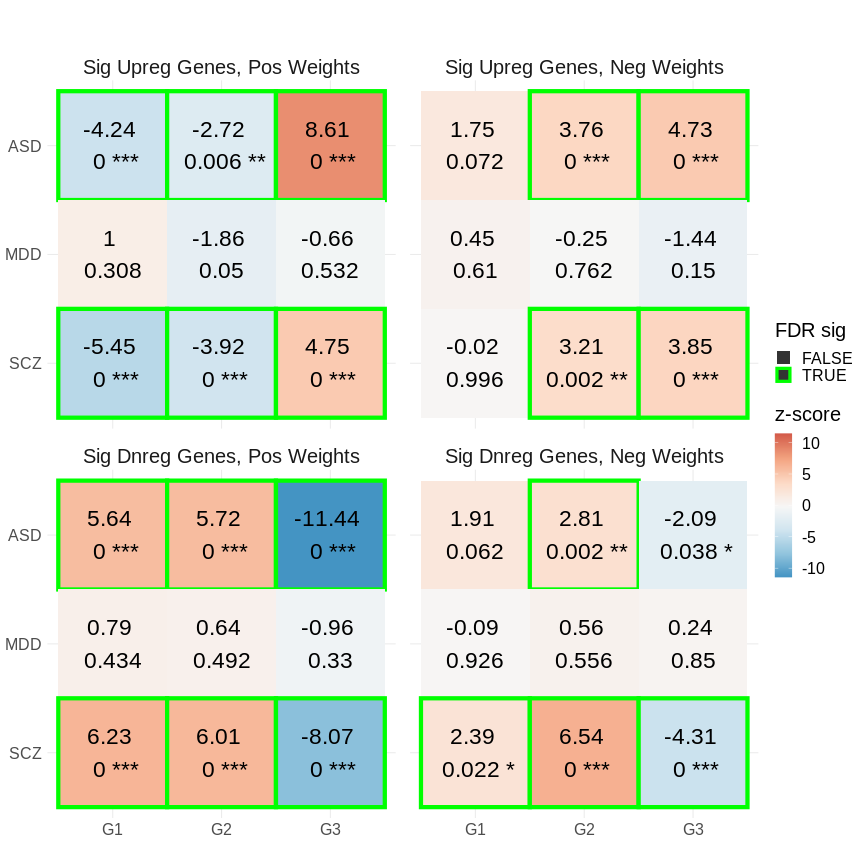

In [771]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [736]:
null_p_versions_dict = {
    'Sig Upreg Genes, Pos Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='pos', combine='union'),
    'Sig Upreg Genes, Neg Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='neg', combine='union'),
    'Sig Dnreg Genes, Pos Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='pos', combine='union'),
    'Sig Dnreg Genes, Neg Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='neg', combine='union')
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

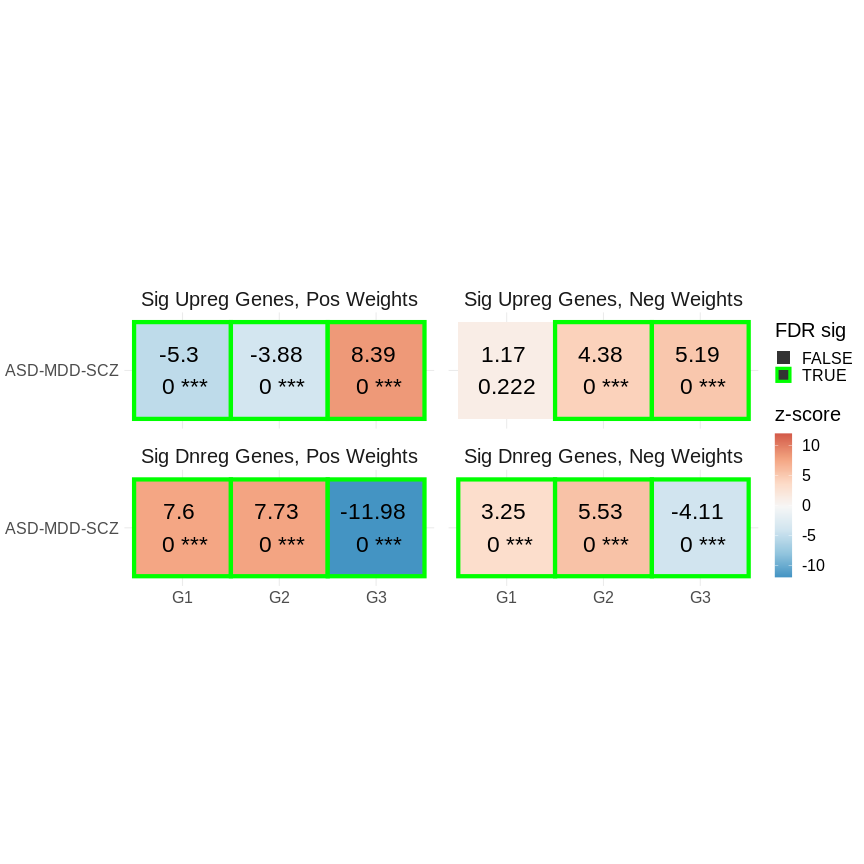

In [737]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [742]:
null_p_versions_dict = {
    'Sig Upreg Genes, Pos Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='pos', combine='ASD-SCZ intersection'),
    'Sig Upreg Genes, Neg Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='neg', combine='ASD-SCZ intersection'),
    'Sig Dnreg Genes, Pos Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='pos', combine='ASD-SCZ intersection'),
    'Sig Dnreg Genes, Neg Weights': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='neg', combine='ASD-SCZ intersection')
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

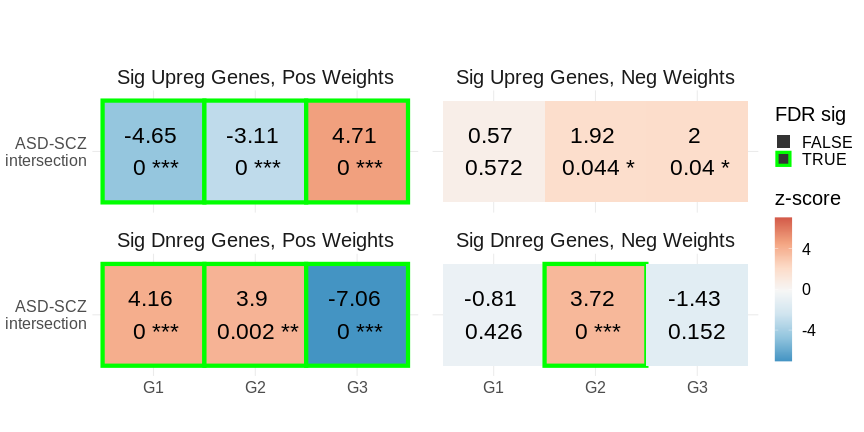

In [769]:
%%R -w 12 -h 6 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [605]:
null_p_versions_dict = {
    'Microarray Gene Sig Upreg, Pos': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='pos'),
    'Microarray Gene Sig Upreg, Neg': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='neg'),
    'Microarray Gene Sig Dnreg, Pos': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='pos'),
    'Microarray Gene Sig Dnreg, Neg': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='neg'),    
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

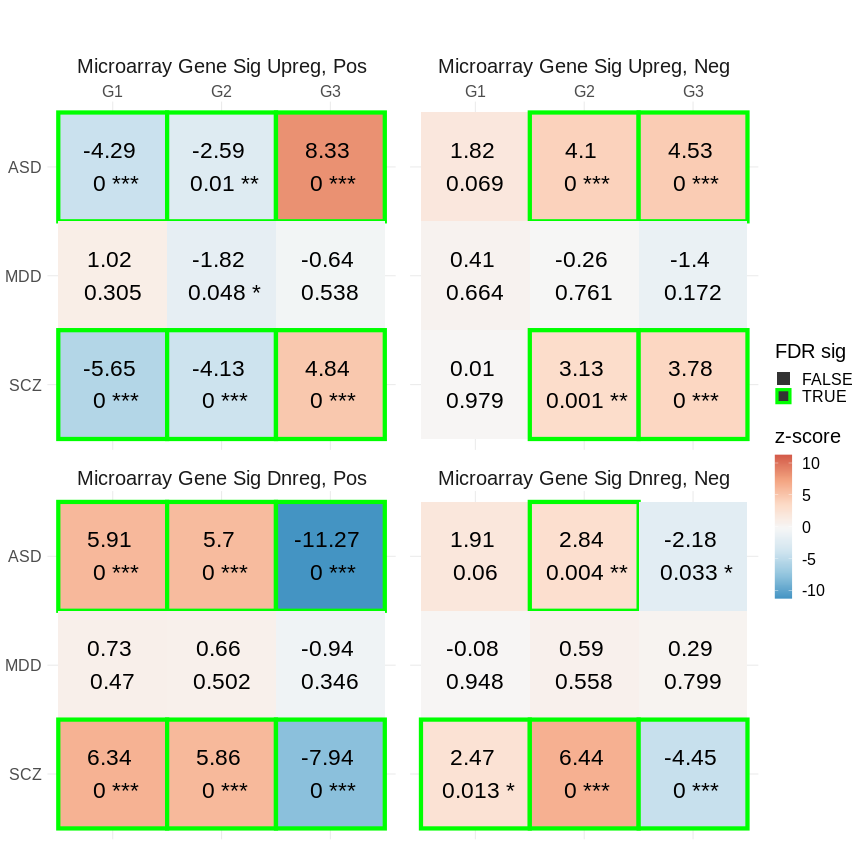

In [606]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [632]:
null_p_versions_dict = {
    'Gene Sig Upreg, Pos': get_gene_sig(weights, null_weights, gandal_genes_rna, posneg='pos', posneg_weights='pos'),
    'Gene Sig Upreg, Neg': get_gene_sig(weights, null_weights, gandal_genes_rna, posneg='pos', posneg_weights='neg'),
    'Gene Sig Dnreg, Pos': get_gene_sig(weights, null_weights, gandal_genes_rna, posneg='neg', posneg_weights='pos'),
    'Gene Sig Dnreg, Neg': get_gene_sig(weights, null_weights, gandal_genes_rna, posneg='neg', posneg_weights='neg'),    
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

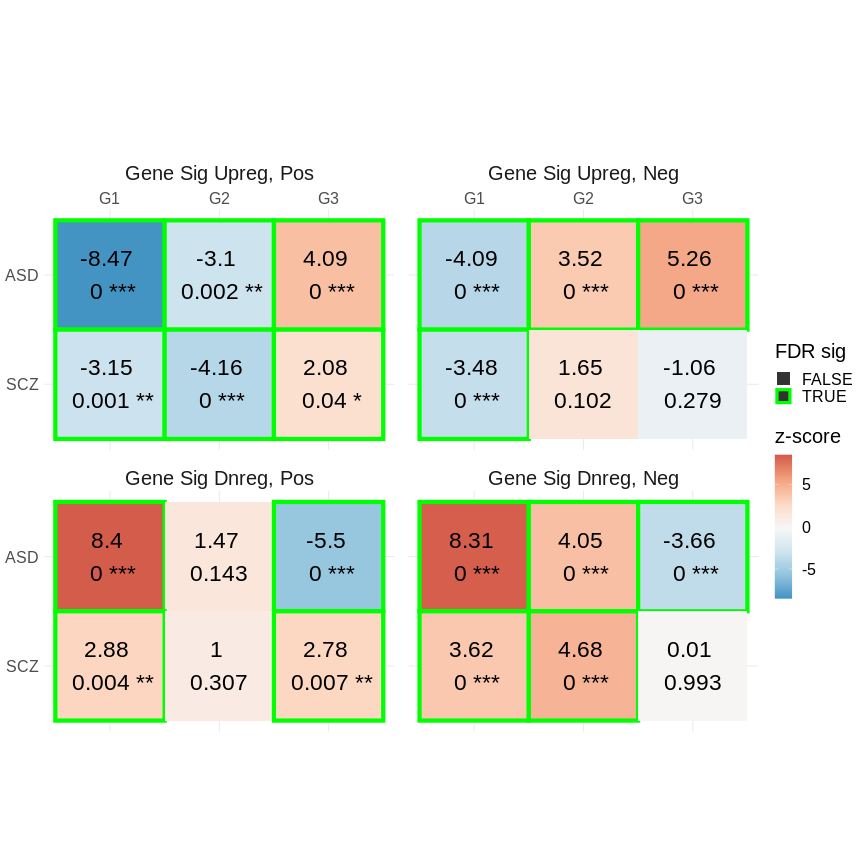

In [633]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [596]:
null_p_versions_dict = {
    'Microarray Gene Dot Upreg, Pos': get_gene_dot(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='pos'),
    'Microarray Gene Dot Upreg, Neg': get_gene_dot(weights, null_weights, gandal_genes_micro, posneg='pos', posneg_weights='neg'),
    'Microarray Gene Dot Dnreg, Pos': get_gene_dot(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='pos'),
    'Microarray Gene Dot Dnreg, Neg': get_gene_dot(weights, null_weights, gandal_genes_micro, posneg='neg', posneg_weights='neg'),    
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

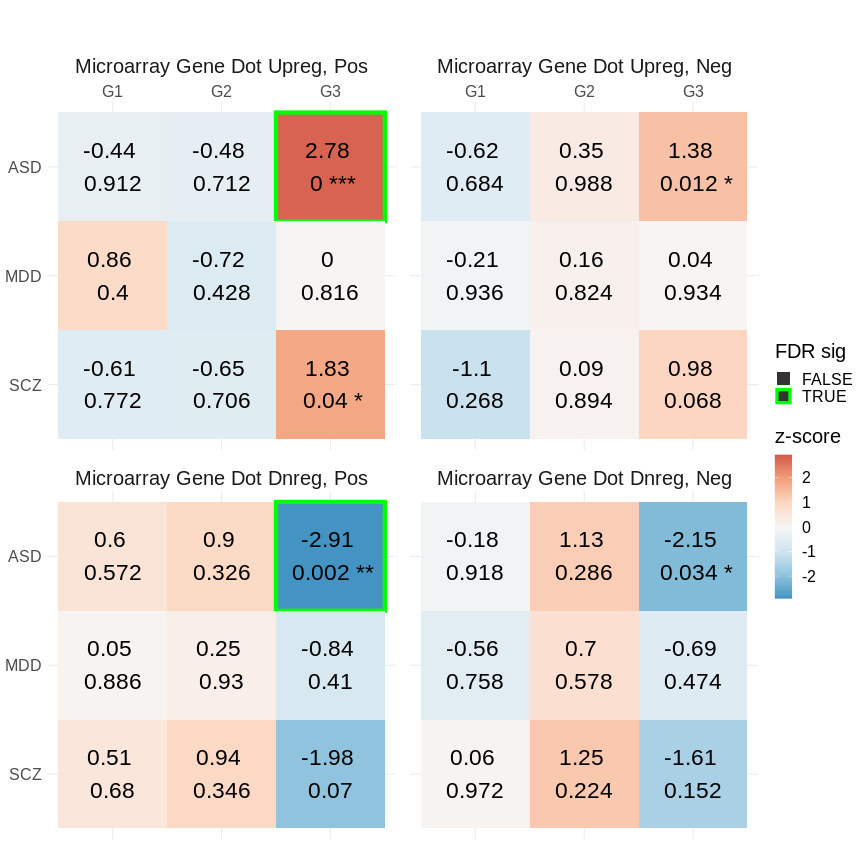

In [598]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [599]:
null_p_versions_dict = {
    'RNAseq Gene Dot Upreg, Pos': get_gene_dot(weights, null_weights, gandal_genes_rna, posneg='pos', posneg_weights='pos'),
    'RNAseq Gene Dot Upreg, Neg': get_gene_dot(weights, null_weights, gandal_genes_rna, posneg='pos', posneg_weights='neg'),
    'RNAseq Gene Dot Dnreg, Pos': get_gene_dot(weights, null_weights, gandal_genes_rna, posneg='neg', posneg_weights='pos'),
    'RNAseq Gene Dot Dnreg, Neg': get_gene_dot(weights, null_weights, gandal_genes_rna, posneg='neg', posneg_weights='neg'),  
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

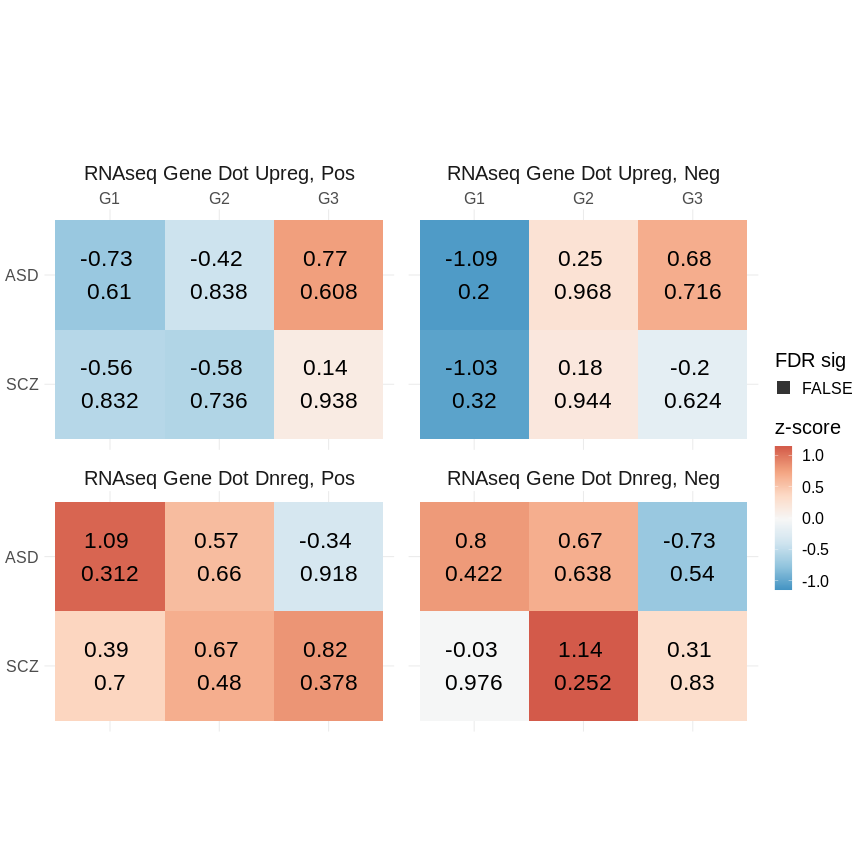

In [600]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [64]:
null_p_versions_dict = {
    'Microarray Gene Abs Dot': get_gene_dot(weights, null_weights, gandal_genes_micro, posneg='abs', absolute=True),
    'RNAseq Gene Abs Dot': get_gene_dot(weights, null_weights, gandal_genes_rna, posneg='abs', absolute=True),
    'Microarray Gene Sig Abs Dot': get_gene_dot(weights, null_weights, gandal_genes_micro, posneg='abs', absolute=True, sig_thresh=.05),
    'RNAseq Gene Sig Abs Dot': get_gene_dot(weights, null_weights, gandal_genes_rna, posneg='abs', absolute=True, sig_thresh=.05)
    
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

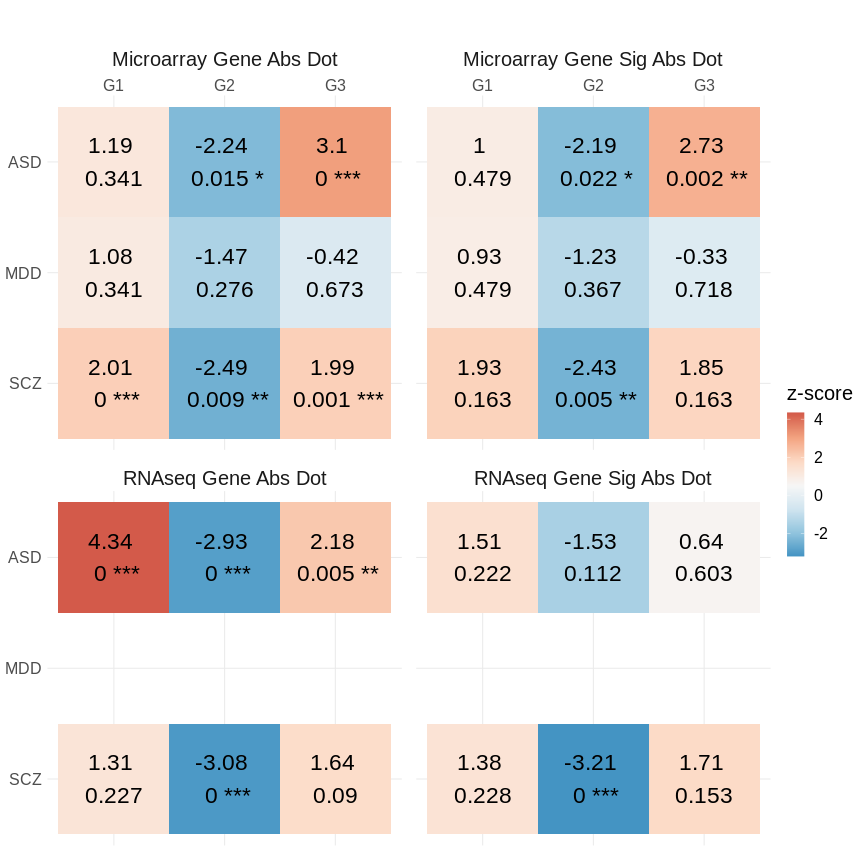

In [65]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

In [31]:
null_p_versions_dict = {
    'Microarray Gene': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='abs'),
    'RNAseq Gene': get_gene_sig(weights, null_weights, gandal_genes_rna, posneg='abs'),
    'Microarray Gene Sig Abs': get_gene_sig(weights, null_weights, gandal_genes_micro, posneg='abs', absolute=True, sig_thresh=.05),
    'RNAseq Gene Sig Abs': get_gene_sig(weights, null_weights, gandal_genes_rna, posneg='abs', absolute=True, sig_thresh=.05)
    
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

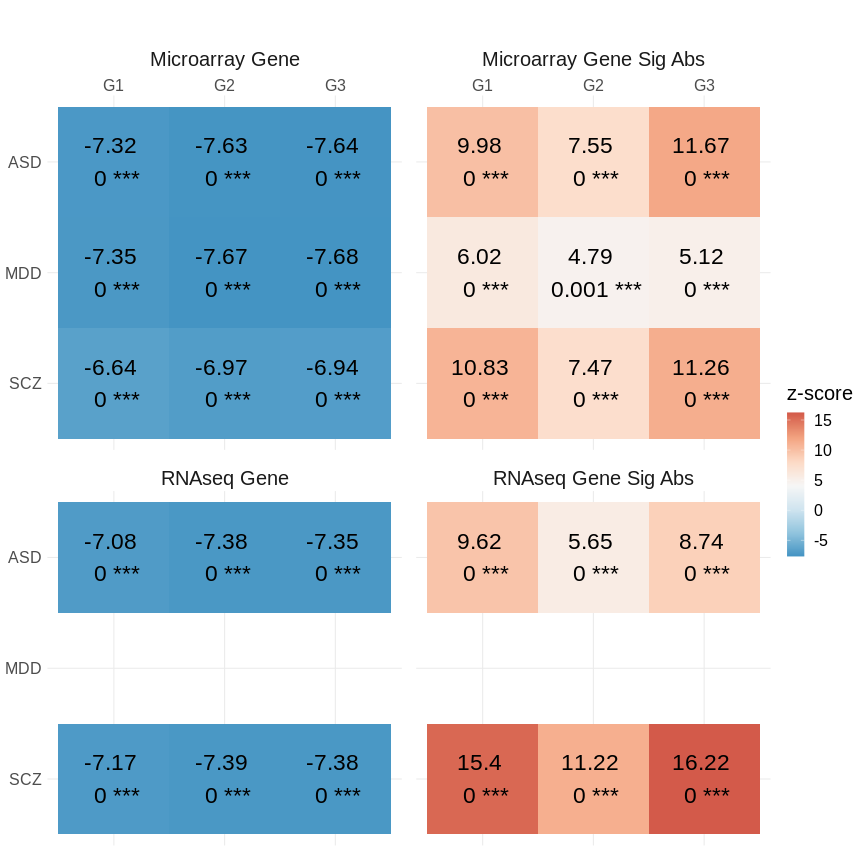

In [32]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions, ncol=2) + ggtitle('')

## Get Gandal genes - RNAseq

In [12]:
gandal_genes = get_gandal_genes(which='rnaseq')

In [415]:
null_weights = null_weights_sim

In [416]:
null_p_sig_pos = get_gene_sig(weights, null_weights, gandal_genes, posneg='pos')
null_p_sig_neg = get_gene_sig(weights, null_weights, gandal_genes, posneg='neg')
null_p_sig_abs = get_gene_sig(weights, null_weights, gandal_genes, posneg='abs')

In [417]:
null_p_dot_pos = get_gene_dot(weights, null_weights, gandal_genes, posneg='pos')
null_p_dot_neg = get_gene_dot(weights, null_weights, gandal_genes, posneg='neg')
null_p_dot_abs = get_gene_dot(weights, null_weights, gandal_genes, posneg='abs')

In [418]:
null_p_dotsig_pos = get_gene_dot(weights, null_weights, gandal_genes, posneg='pos', sig_thresh=.05)
null_p_dotsig_neg = get_gene_dot(weights, null_weights, gandal_genes, posneg='neg', sig_thresh=.05)
null_p_dotsig_abs = get_gene_dot(weights, null_weights, gandal_genes, posneg='abs', sig_thresh=.05)

In [419]:
null_p_map_pos = get_gene_map_corr(version, null_scores, gandal_genes, posneg='pos')
null_p_map_neg = get_gene_map_corr(version, null_scores, gandal_genes, posneg='neg')
null_p_map_abs = get_gene_map_corr(version, null_scores, gandal_genes, posneg='')

In [420]:
null_p_versions_dict = {
    'Sig log2FC Up': null_p_sig_pos,
    'Sig log2FC Down': null_p_sig_neg,
    'Sig log2FC Abs': null_p_sig_abs,
    'Dot log2FC Up': null_p_dot_pos,
    'Dot log2FC Down': null_p_dot_neg,
    'Dot log2FC Abs': null_p_dot_abs,
    'Dot Sig log2FC Up': null_p_dotsig_pos,
    'Dot Sig log2FC Down': null_p_dotsig_neg,
    'Dot Sig log2FC Abs': null_p_dotsig_abs,    
    'Cor Gene Map Up': null_p_map_pos,
    'Cor Gene Map Down': null_p_map_neg,
    'Cor Gene Map Abs': null_p_map_abs,
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

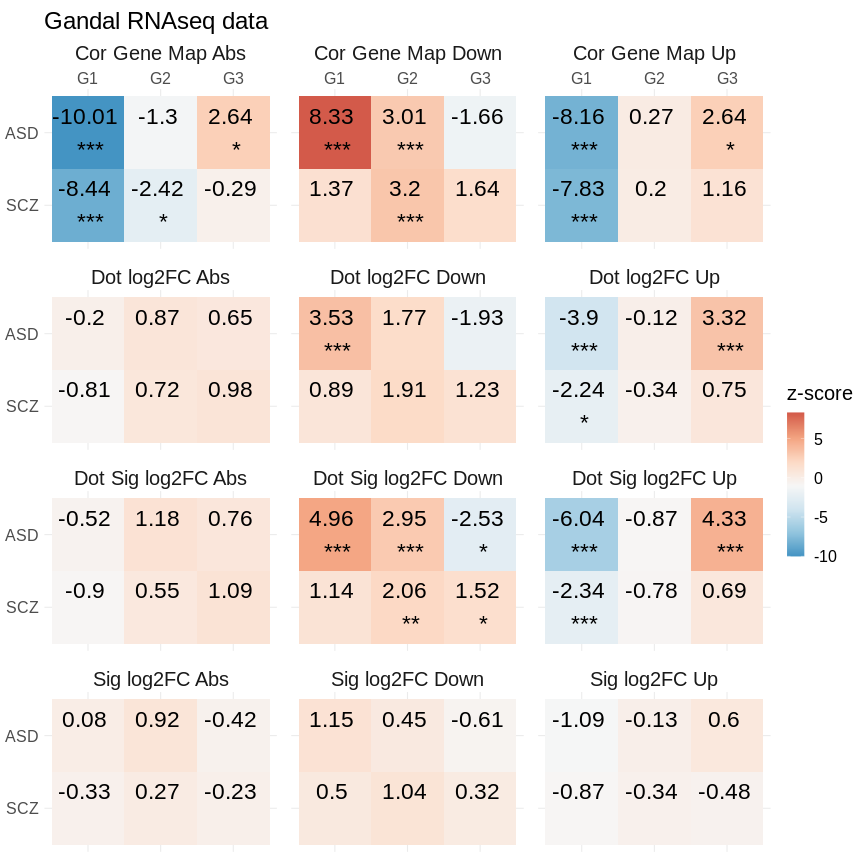

In [425]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions) + ggtitle('Gandal RNAseq data')

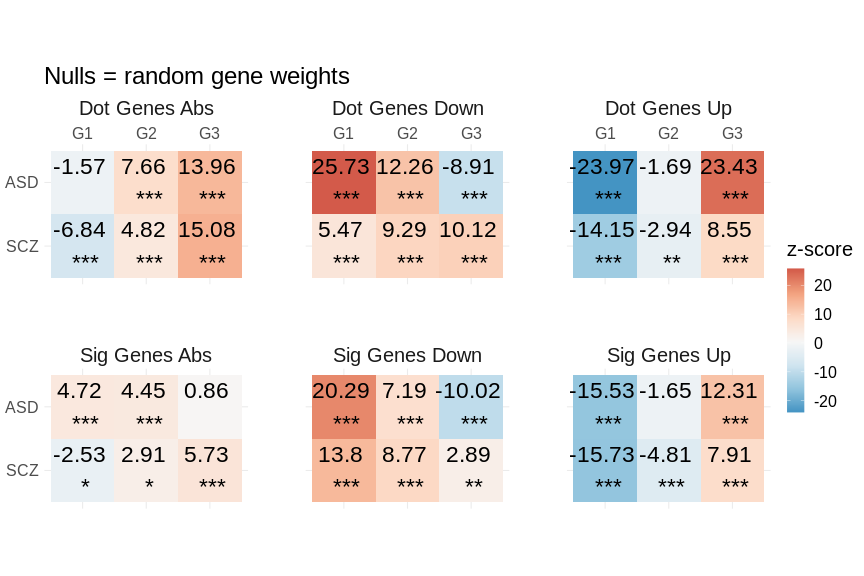

In [138]:
%%R -w 12 -h 8 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions) + ggtitle('Nulls = random gene weights')

## Get Gandal genes - microarray

In [426]:
gandal_genes = get_gandal_genes(which='microarray')

In [427]:
# null_weights = null_weights_shuffle
null_weights = null_weights_sim

In [428]:
null_p_sig_pos = get_gene_sig(weights, null_weights, gandal_genes, posneg='pos')
null_p_sig_neg = get_gene_sig(weights, null_weights, gandal_genes, posneg='neg')
null_p_sig_abs = get_gene_sig(weights, null_weights, gandal_genes, posneg='abs')

In [429]:
null_p_dot_pos = get_gene_dot(weights, null_weights, gandal_genes, posneg='pos')
null_p_dot_neg = get_gene_dot(weights, null_weights, gandal_genes, posneg='neg')
null_p_dot_abs = get_gene_dot(weights, null_weights, gandal_genes, posneg='abs')

In [430]:
null_p_dotsig_pos = get_gene_dot(weights, null_weights, gandal_genes, posneg='pos', sig_thresh=.05)
null_p_dotsig_neg = get_gene_dot(weights, null_weights, gandal_genes, posneg='neg', sig_thresh=.05)
null_p_dotsig_abs = get_gene_dot(weights, null_weights, gandal_genes, posneg='abs', sig_thresh=.05)

In [431]:
null_p_map_pos = get_gene_map_corr(version, null_scores, gandal_genes, posneg='pos')
null_p_map_neg = get_gene_map_corr(version, null_scores, gandal_genes, posneg='neg')
null_p_map_abs = get_gene_map_corr(version, null_scores, gandal_genes, posneg='')

In [432]:
null_p_versions_dict = {
    'Sig log2FC Up': null_p_sig_pos,
    'Sig log2FC Down': null_p_sig_neg,
    'Sig log2FC Abs': null_p_sig_abs,
    'Dot log2FC Up': null_p_dot_pos,
    'Dot log2FC Down': null_p_dot_neg,
    'Dot log2FC Abs': null_p_dot_abs,
    'Dot Sig log2FC Up': null_p_dotsig_pos,
    'Dot Sig log2FC Down': null_p_dotsig_neg,
    'Dot Sig log2FC Abs': null_p_dotsig_abs,    
    'Cor Gene Map Up': null_p_map_pos,
    'Cor Gene Map Down': null_p_map_neg,
    'Cor Gene Map Abs': null_p_map_abs,
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

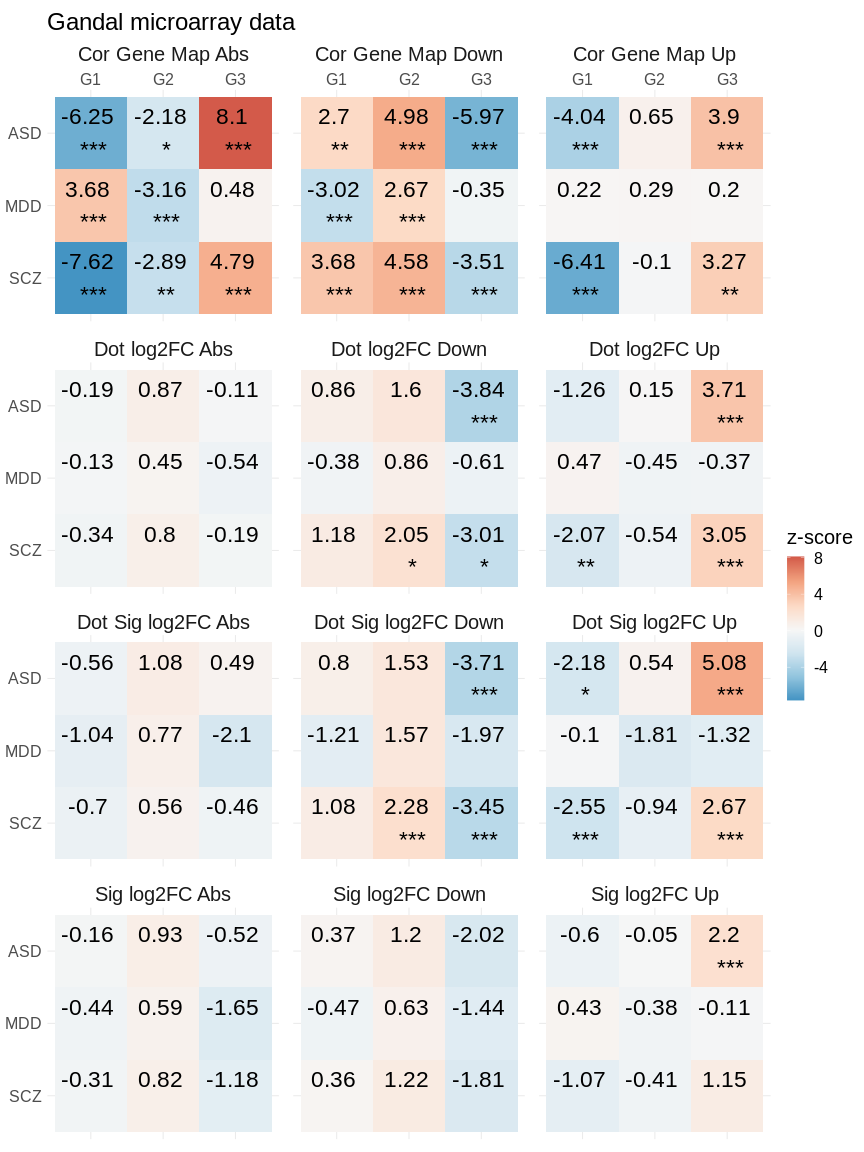

In [433]:
%%R -w 12 -h 16 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions) + ggtitle('Gandal microarray data')

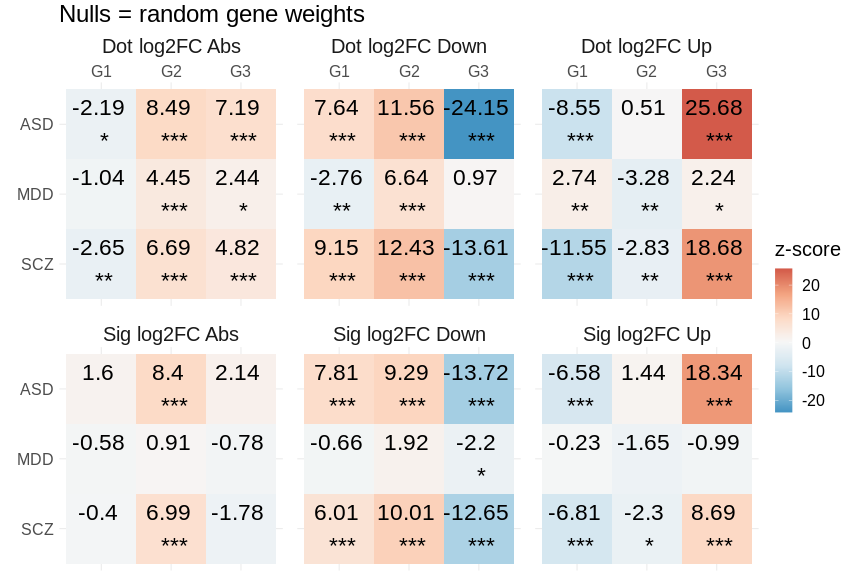

In [256]:
%%R -w 12 -h 8 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions) + ggtitle('Nulls = random gene weights')

## Do map correlations with eigengene map

In [274]:
gandal_genes_micro = get_gandal_genes(which='microarray')
gandal_genes_rna = get_gandal_genes(which='rnaseq')

In [291]:
null_p_versions_dict = {
    'Microarray': get_gene_map_corr(version, null_scores, gandal_genes_micro, posneg='abs', method='mean')
}

null_p_versions = (pd.concat(null_p_versions_dict)
                   .reset_index(0)
                   .rename({'level_0':'version'}, axis=1)
                  )

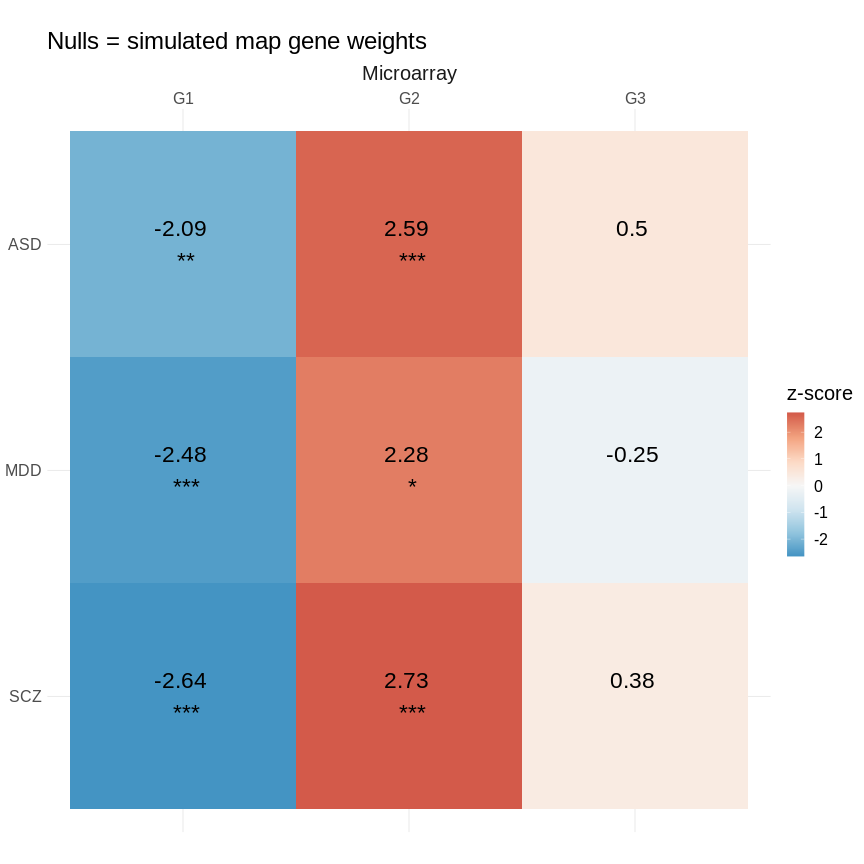

In [292]:
%%R -w 12 -h 12 --units in -i null_p_versions
source("../code/enrichmentsPlots.R")
plot_enrichment_heatmaps(null_p_versions) + ggtitle('Nulls = simulated map gene weights')